# Introduction
Ookla for Good™ is an initiative to provide data, analysis, and content to organizations that are seeking to improve people’s lives through internet accessibility. Ookla partners with organizations whose goals align with theirs to provide unbiased information about the state of networks worldwide

## Dataset Description
Ookla's dataset relies on user-generated speedtest information. Everytime a users conducts a speedtest on their laptop or mobile phone using fixed or broadband internet connections, variables related to the internet connection and the user are recorded. This data is then processed to generate indicators such as number of users who conducted the test, download speed, upload speed and latency. The open dataset can be downloaded from AWS S3 and it is available quarterly at quadkey zoom level 16. It has `Global Fixed Broadband` & `Mobile Network Maps`. Through the Development Data Partnership, a more disaggregated and detailed file can be obtained.

The variables available in the opensource dataset are:
- tile: Tile quadkey at level 16.
- tile_x, tile_y: x and y from tile centroid. Not available every year.
- avg_d_kbps: Average download speed in Kbps.
- avg_u_kbps: Average upload speed in Kbps.
- avg_lat_ms: Average latency in ms.
- avg_lat_down_ms: Average latency download in ms.
- avg_lat_up_ms: Average latency upload in ms.
- tests: Number of tests that produced the result.
- devices: Number of devices that produced the result.

For this analysis we are going to study average dowloading speeds at Quadkey level 12. 

## Data Quality
### Speeds Distribution
In order to verify the quality of the data, we plot the speed distribution by dataset (each quarter of the year) for each country. We did not find unexpected results. 

In [3]:
import pandas as pd
import mercantile
from shapely.geometry import box
import geopandas as gpd
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import rasterio
from rasterstats import zonal_stats
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
path_data = '/home/sol/gitrepo/MENA-FCV-economic-monitor/data/'
zoom = 12
net_type = 'fixed'

In [8]:
iso_codes = [
    "afg", "are", "bhr", "dji", "dza", "egy", "irn", "irq", "jor", "kwt",
    "lbn", "lby", "mar", "omn", "pak", "pse", "qat", "sau", "syr", "tun", "yem"]
iso_codes = [x.upper() for x in iso_codes]

In [12]:
for country, gdf in countries_gdf.items():
    print(country)
    if not(country in ["lbn"]):
        continue
    
    raster_stats = zonal_stats(gdf,
               path_data + f'worldpop/{country}_ppp_2020_UNadj_constrained.tif',
               stats = ['sum'])
    pop_by_quadkey = [elem['sum'] if elem['sum'] is not None else 0 for elem in raster_stats]
    gdf['population'] = pop_by_quadkey
    countries_gdf[country] = gdf
    # gdf.to_file(f'../results/gdf_{country}.gpkg')

are
bhr
dji
dza
egy
irn
irq
jor
kwt
lbn
lby
mar
omn
qat
sau
syr
tun
yem


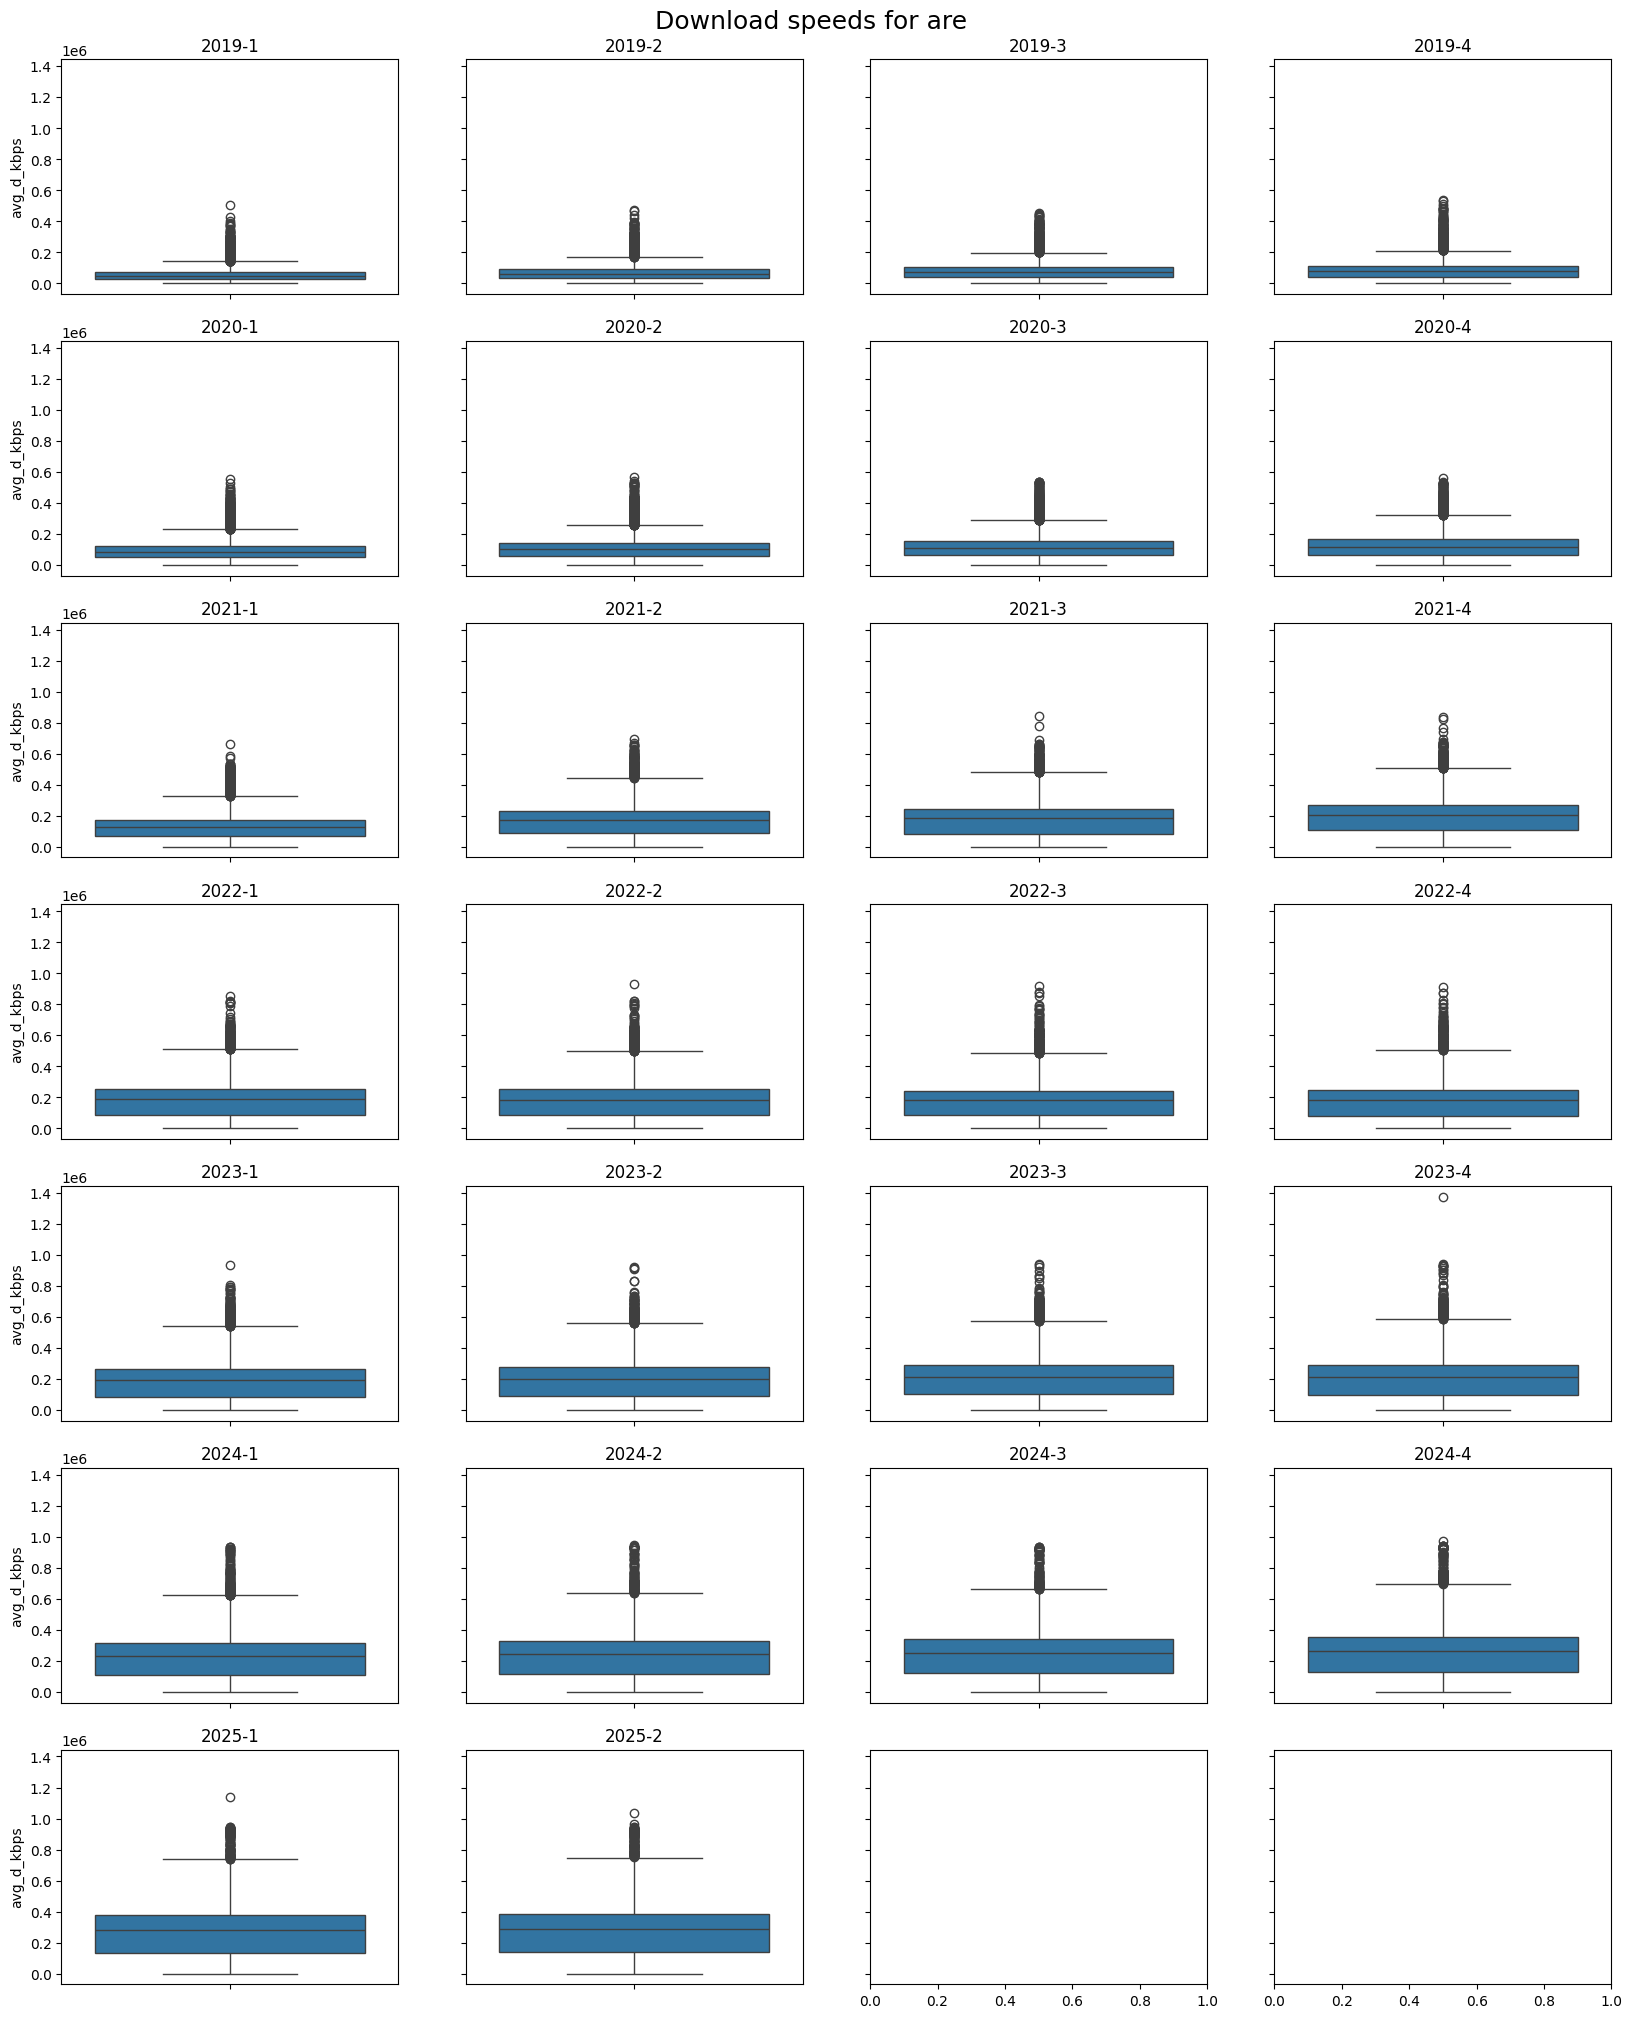

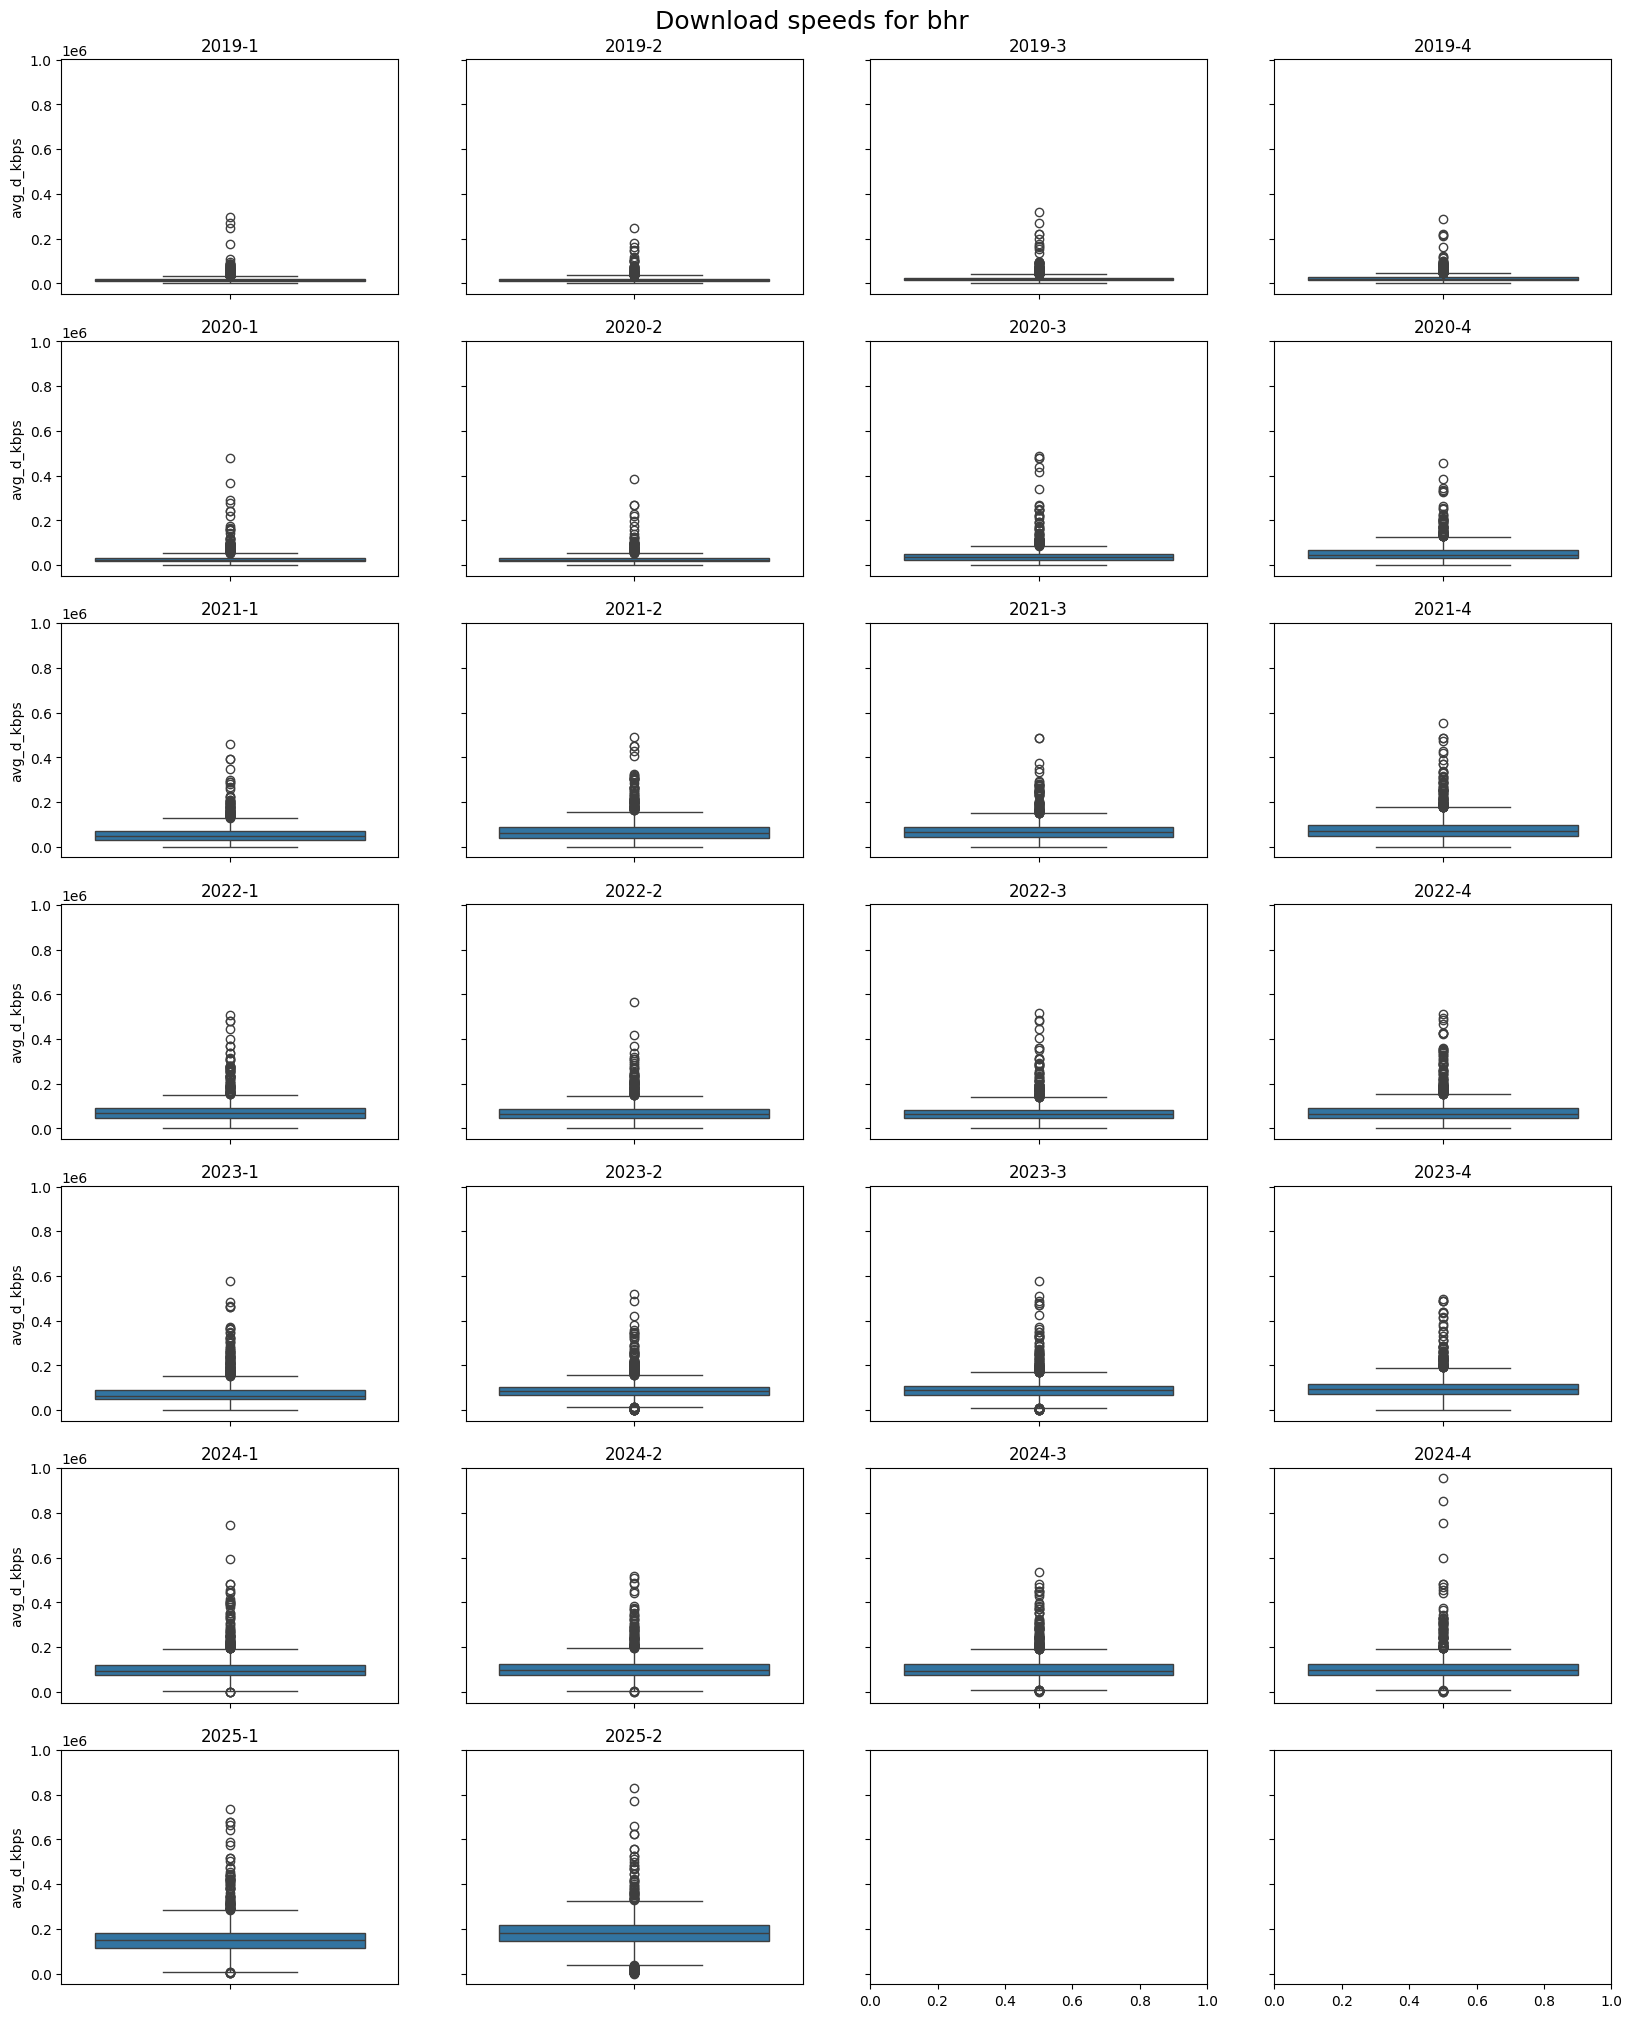

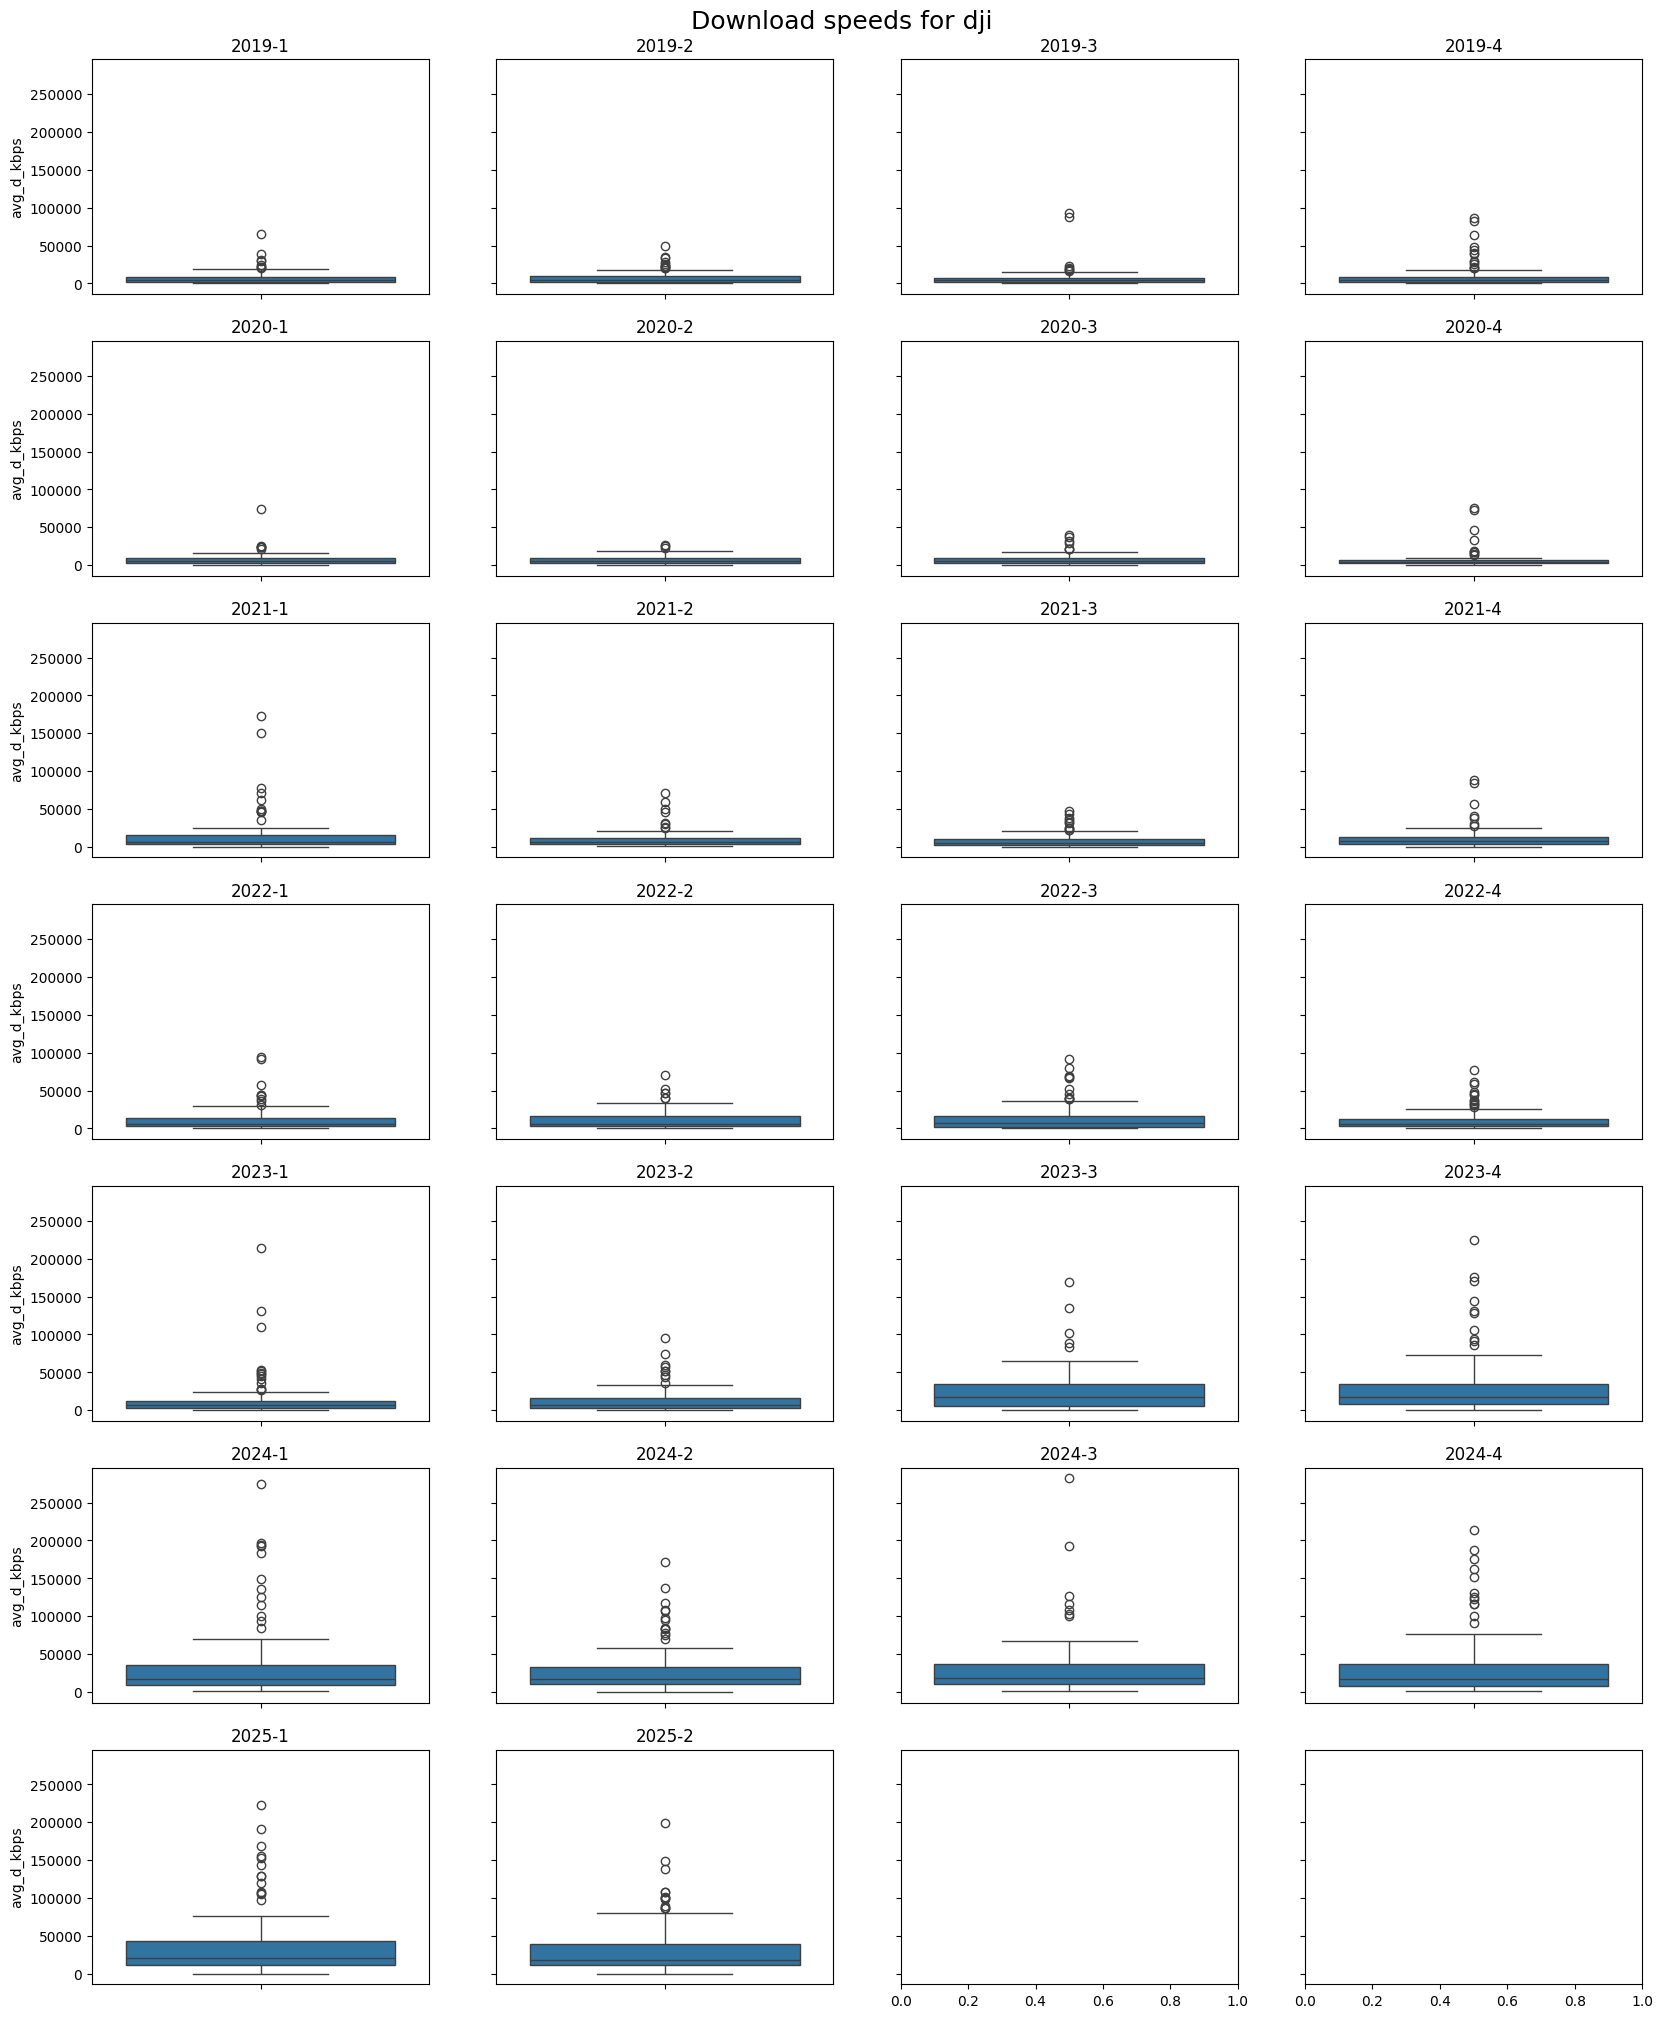

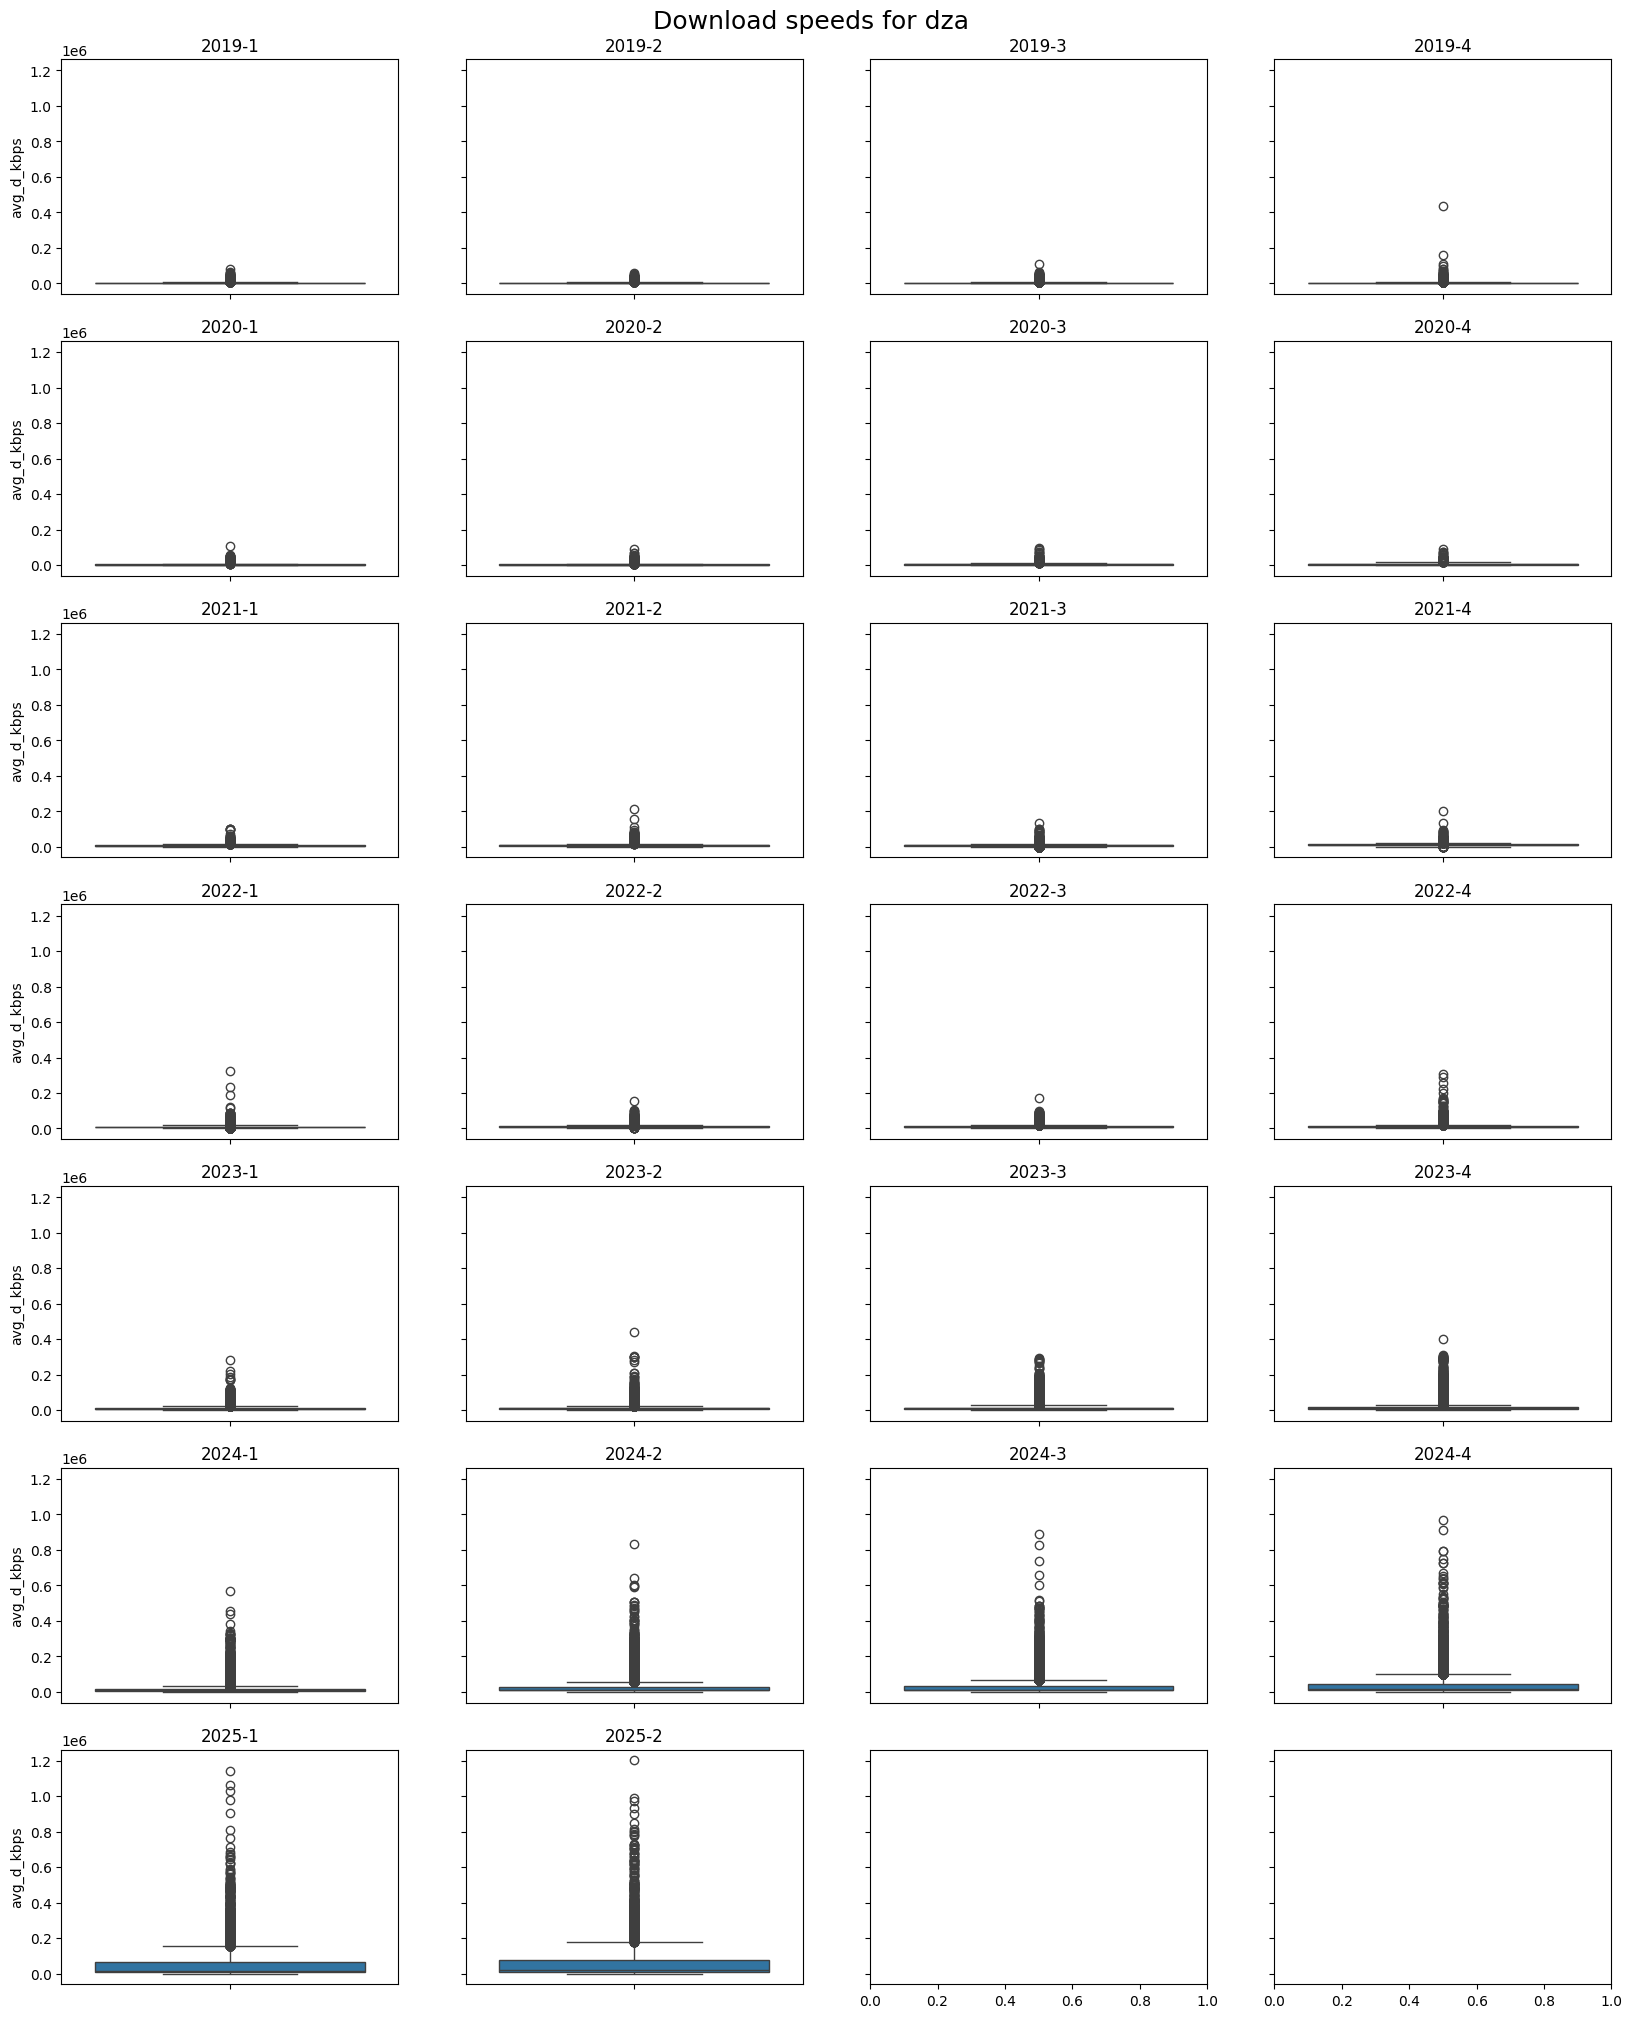

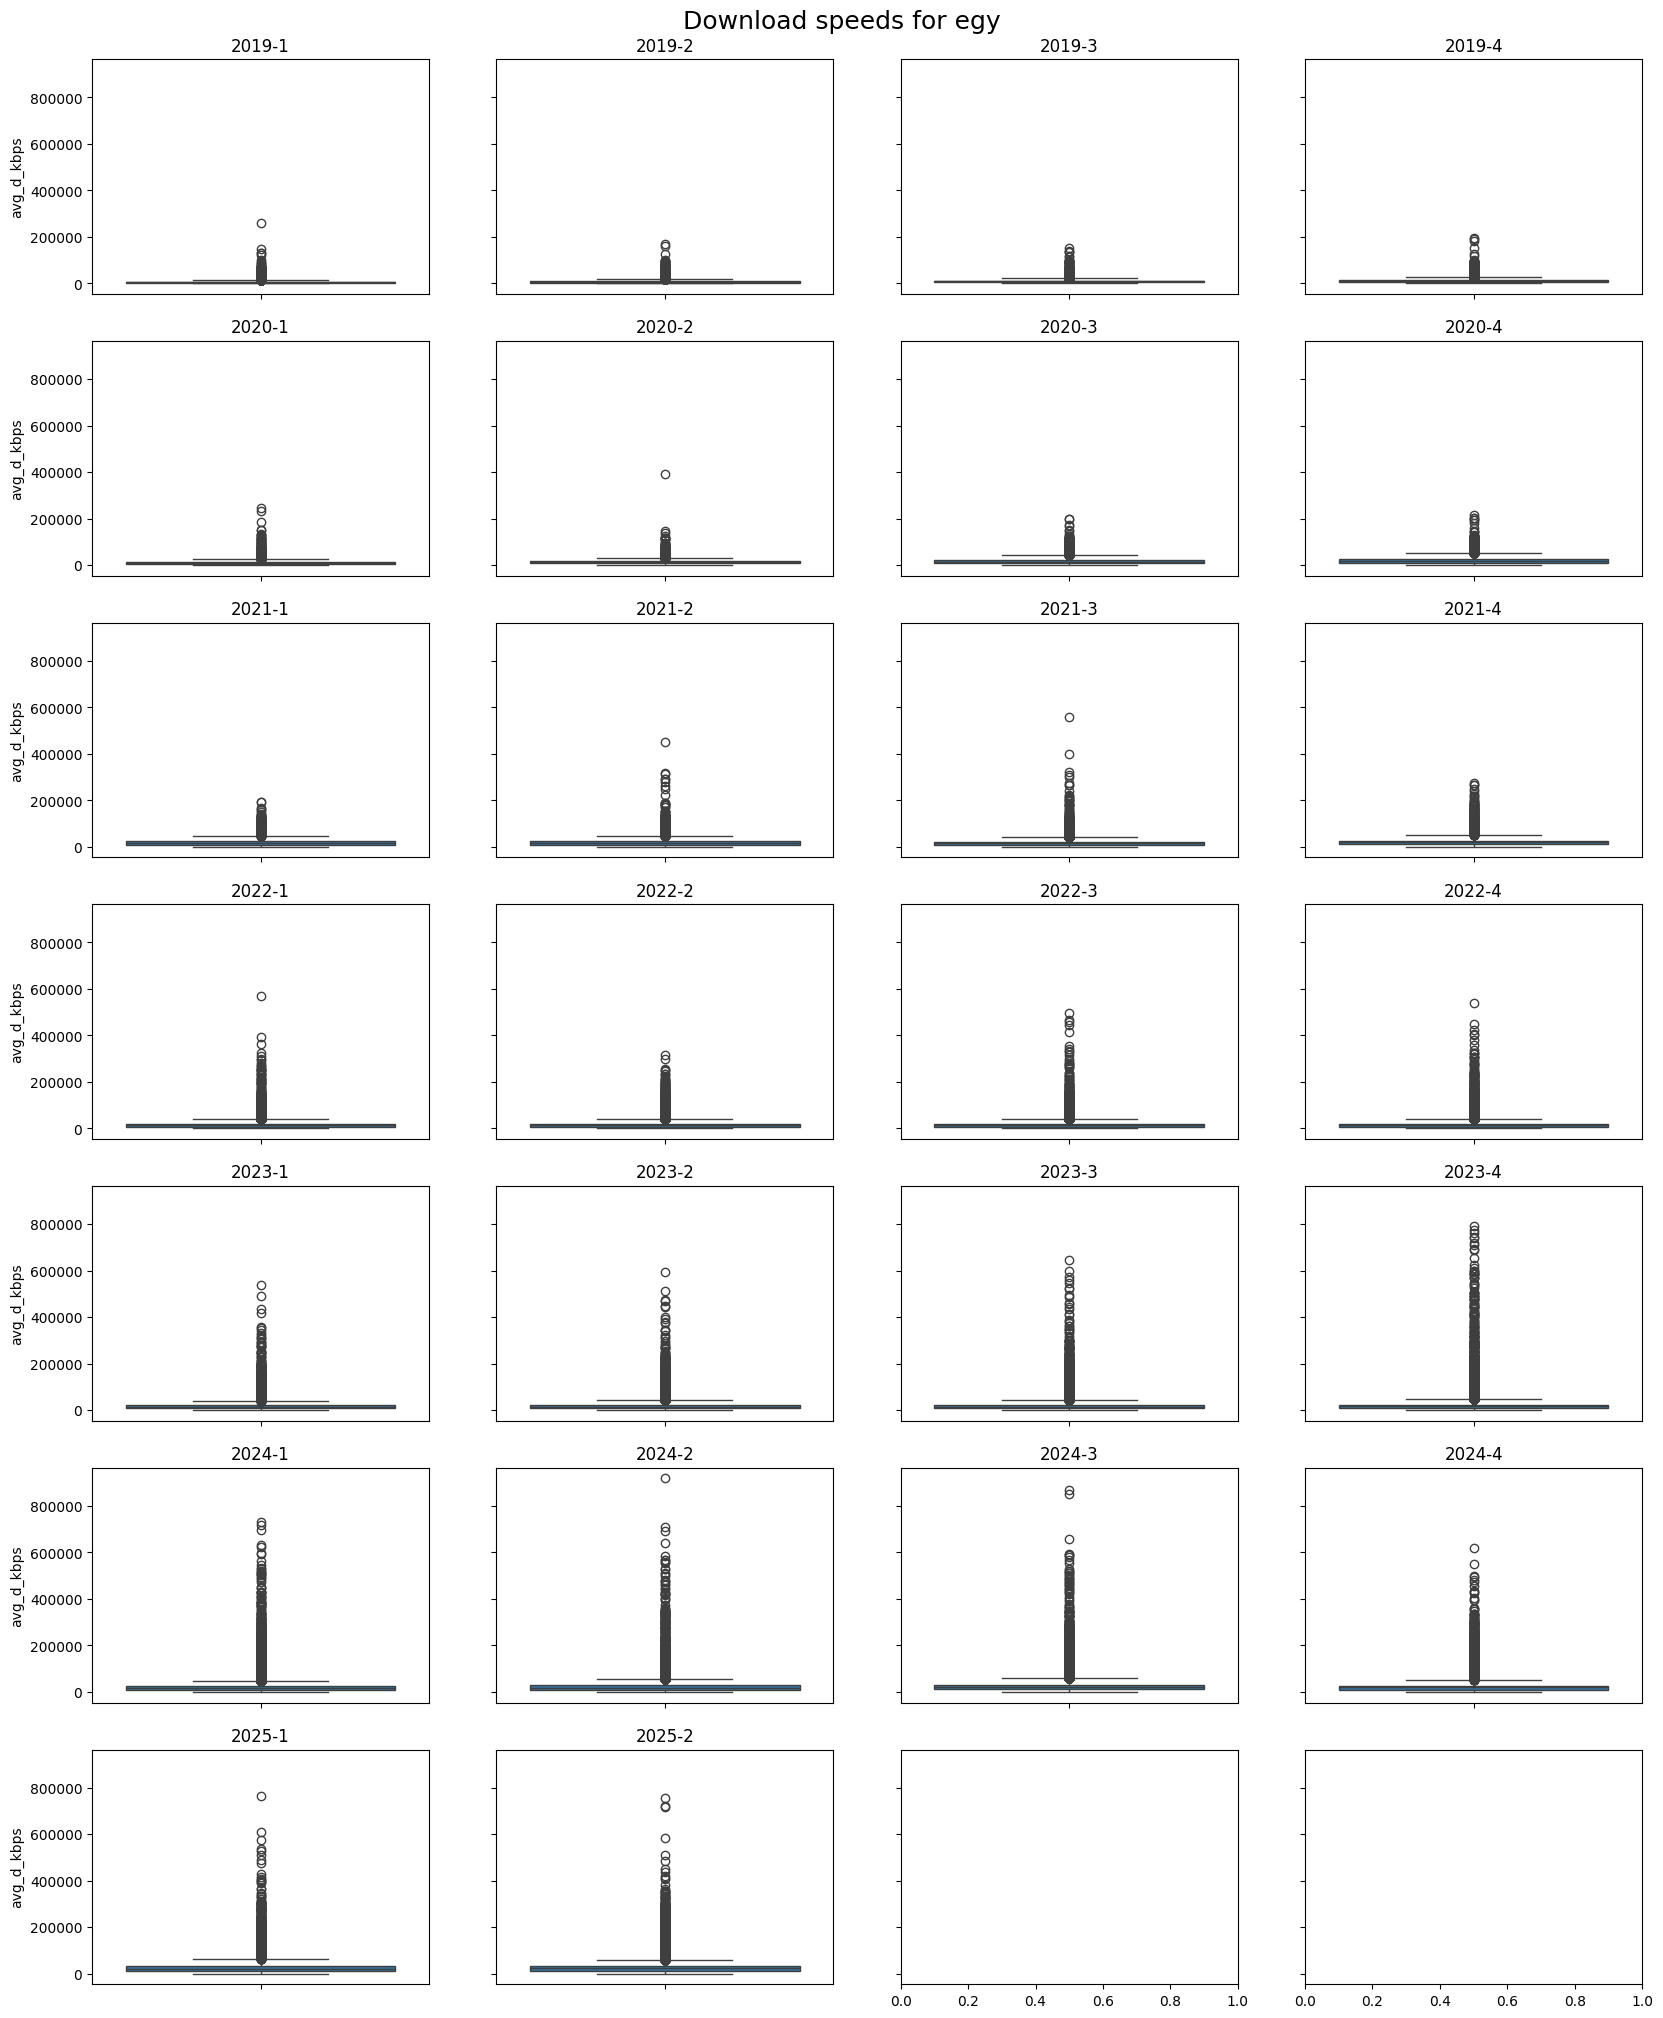

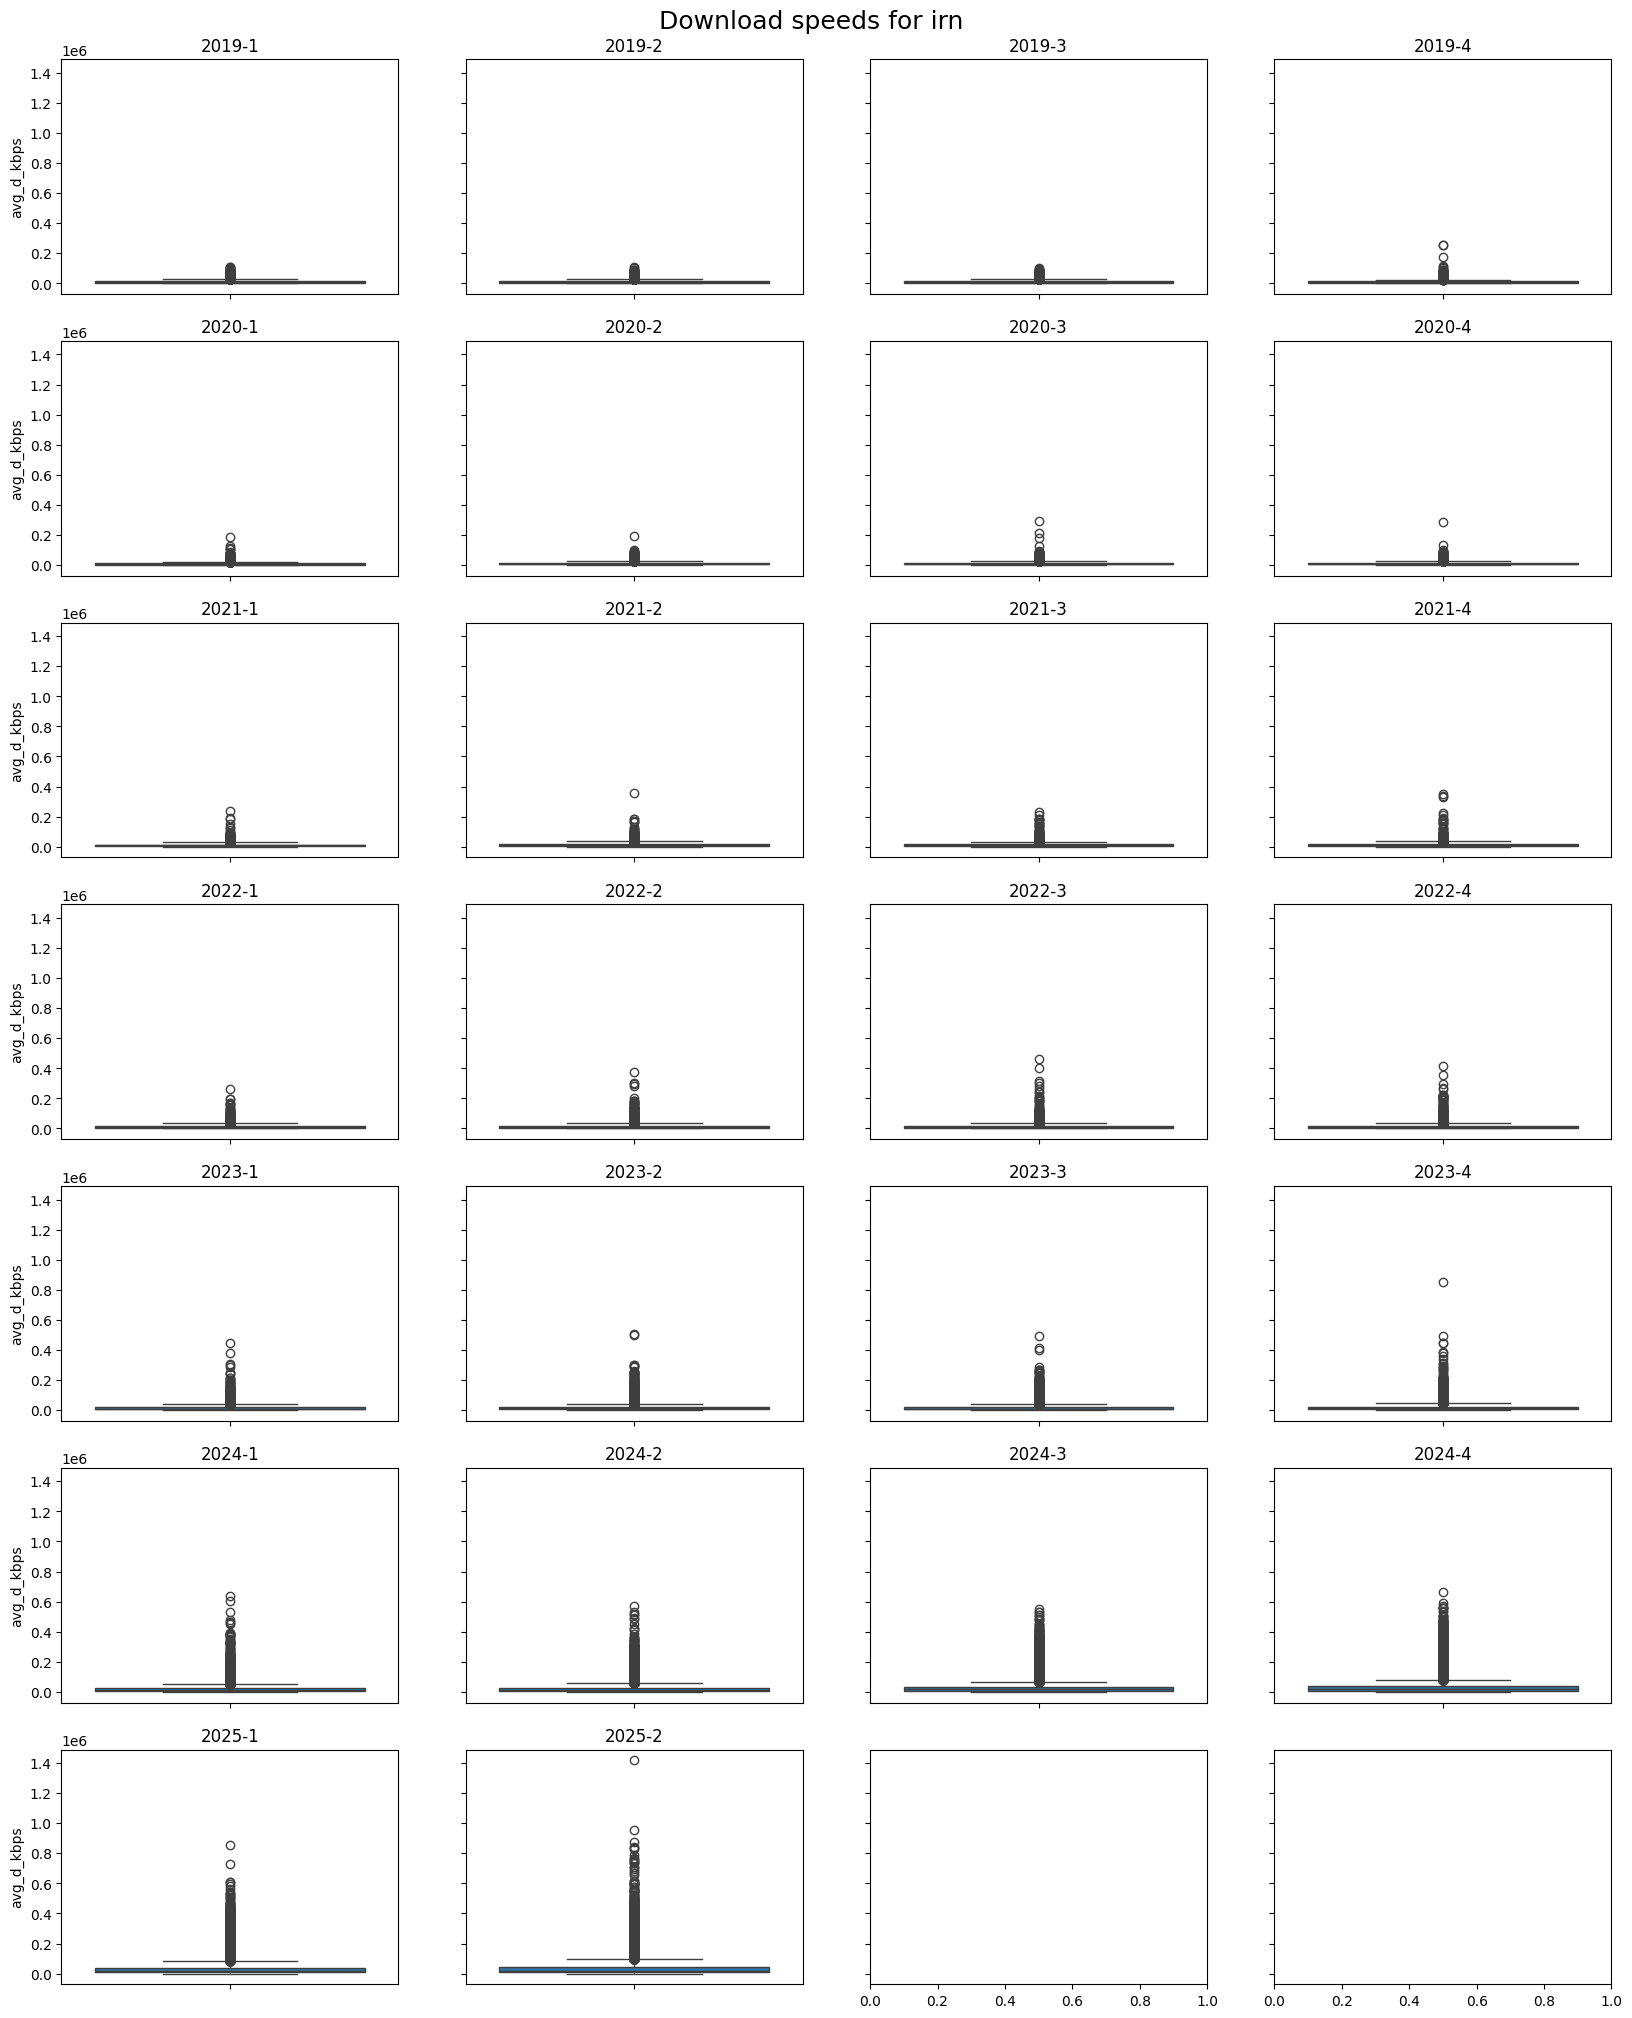

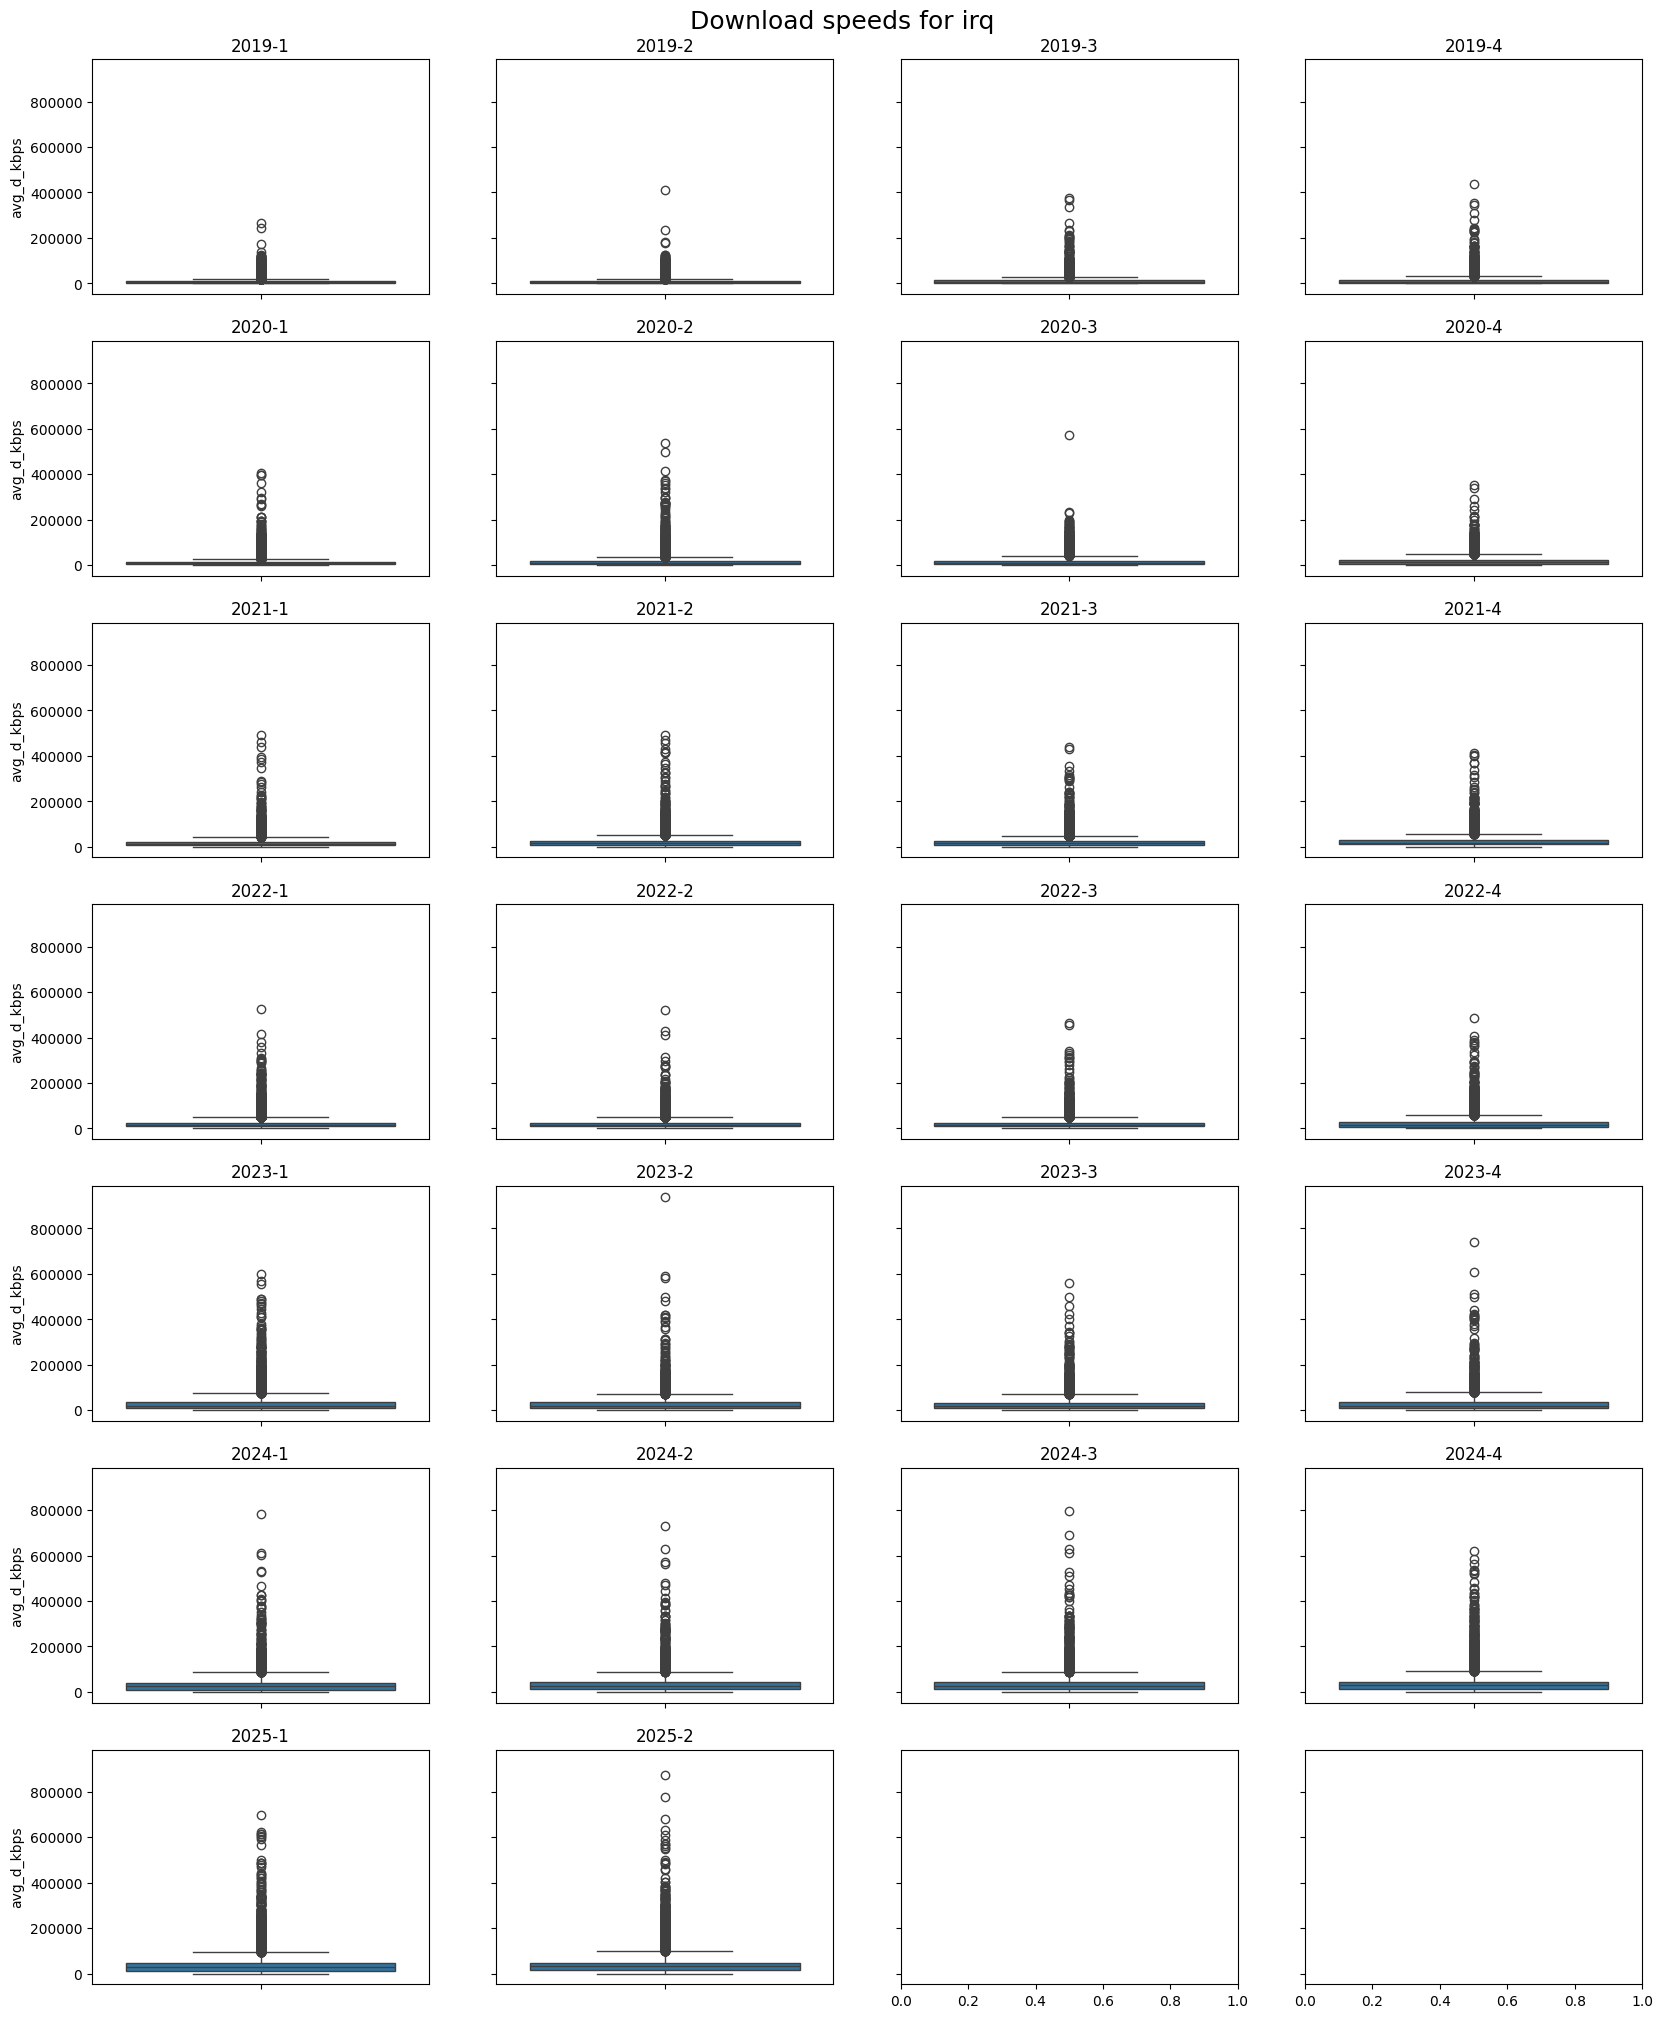

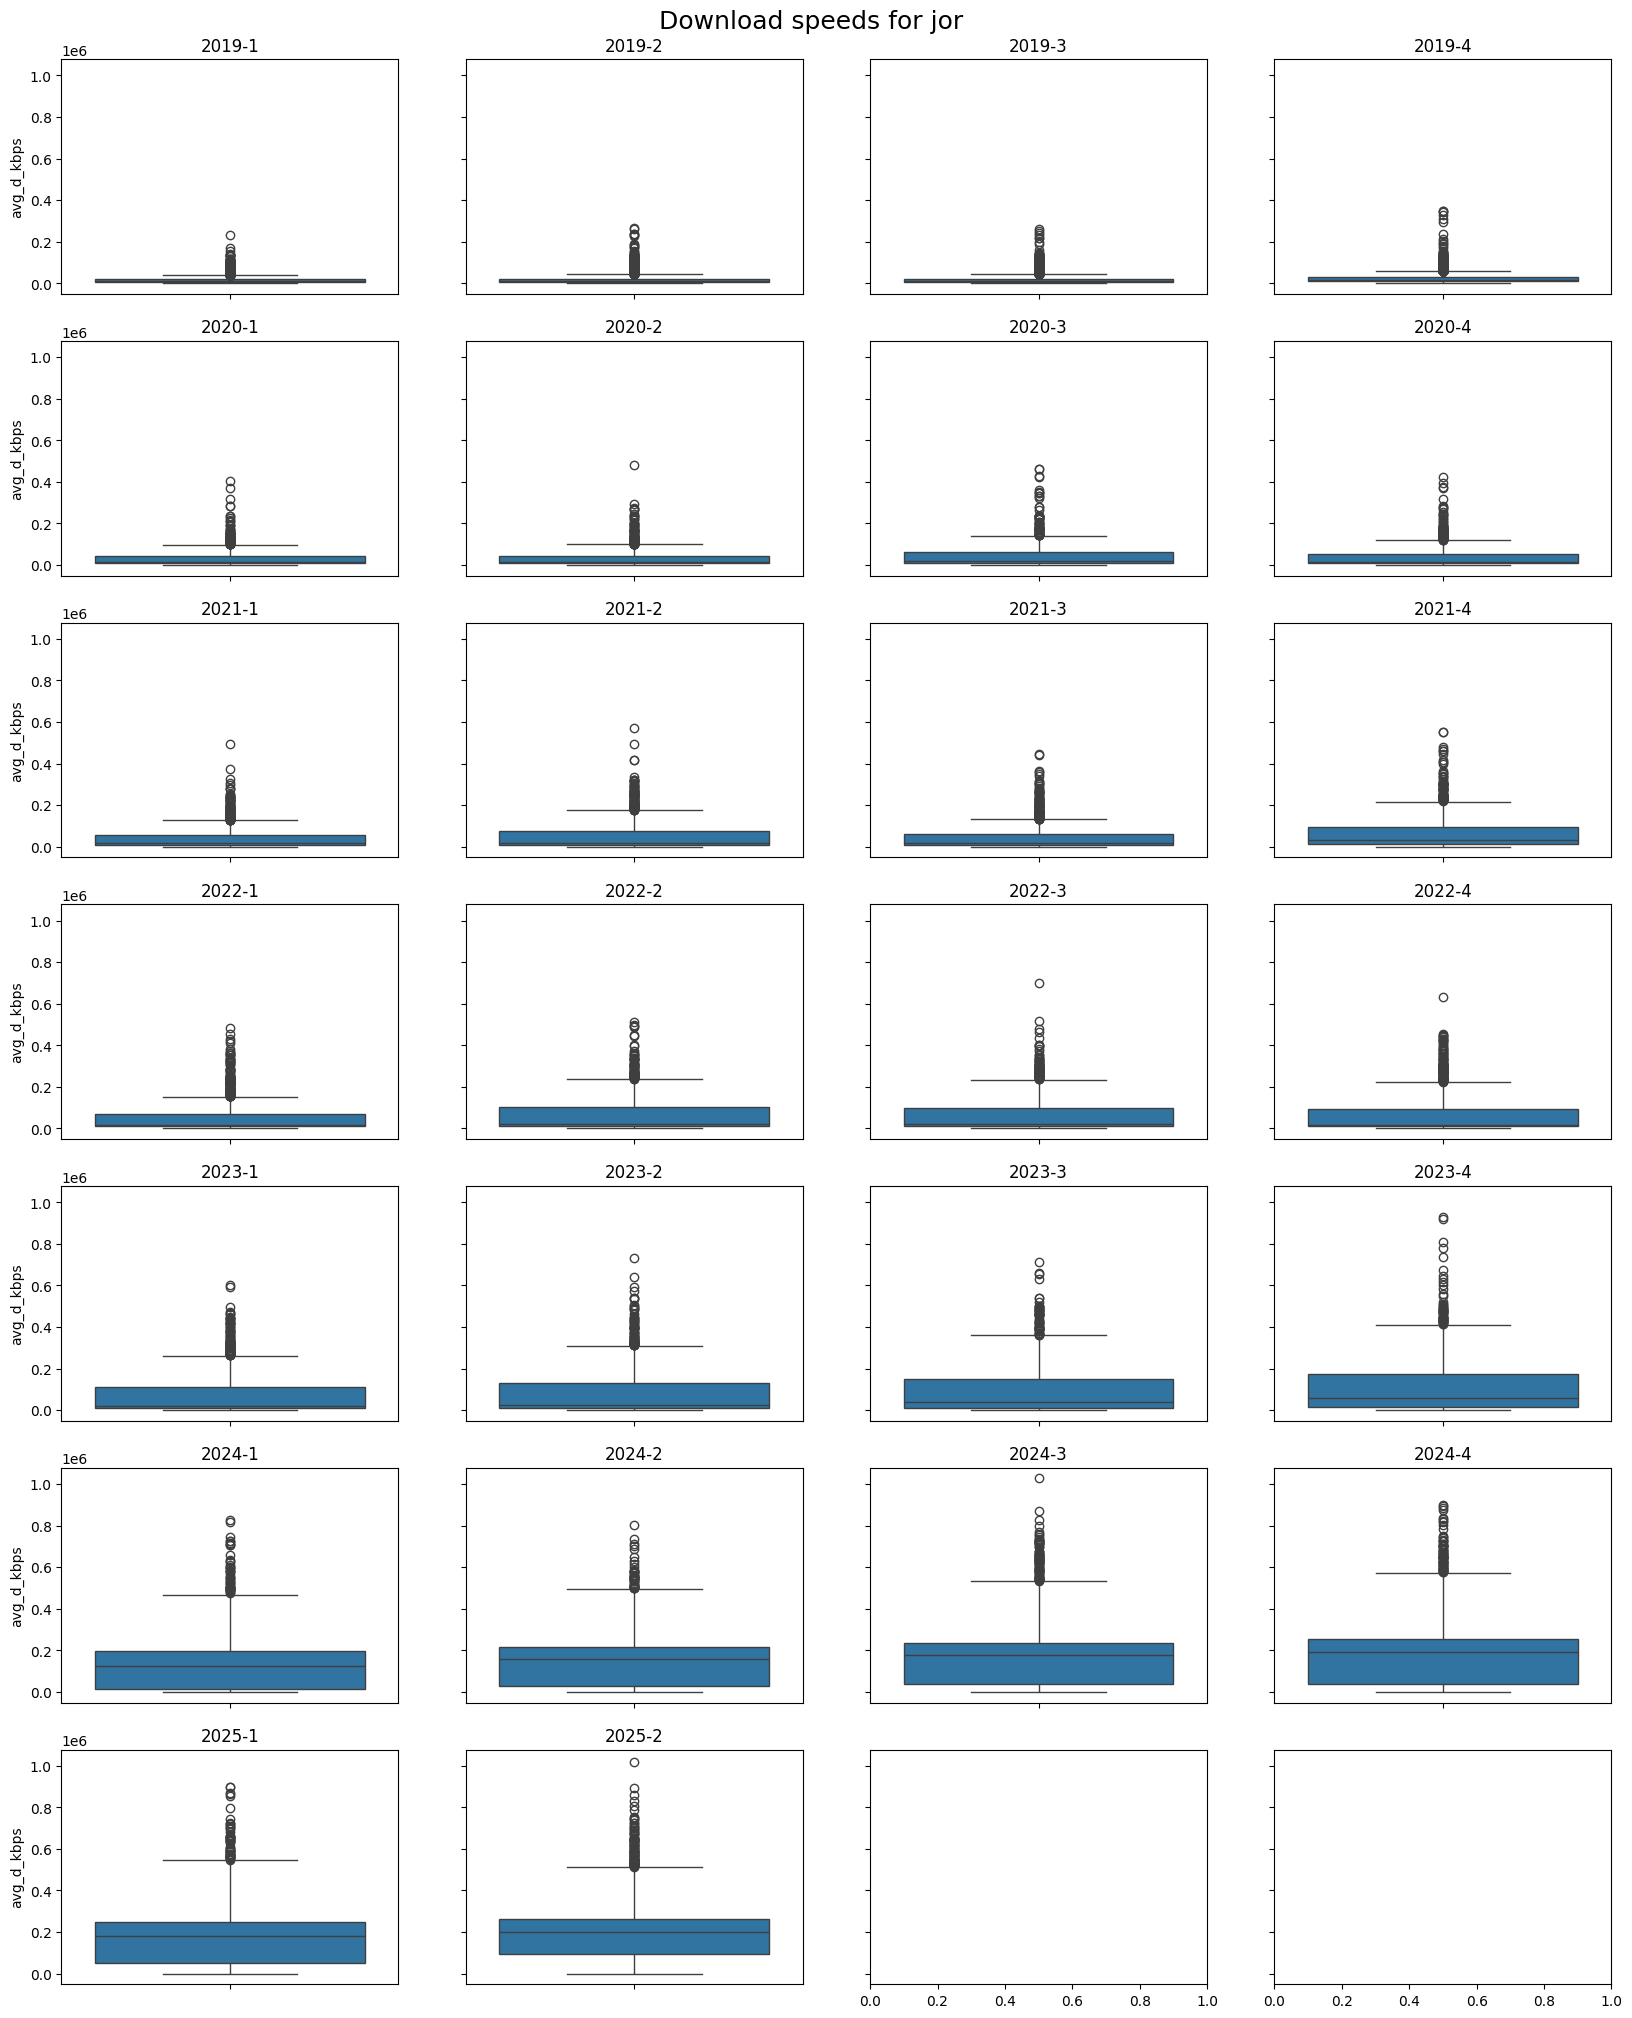

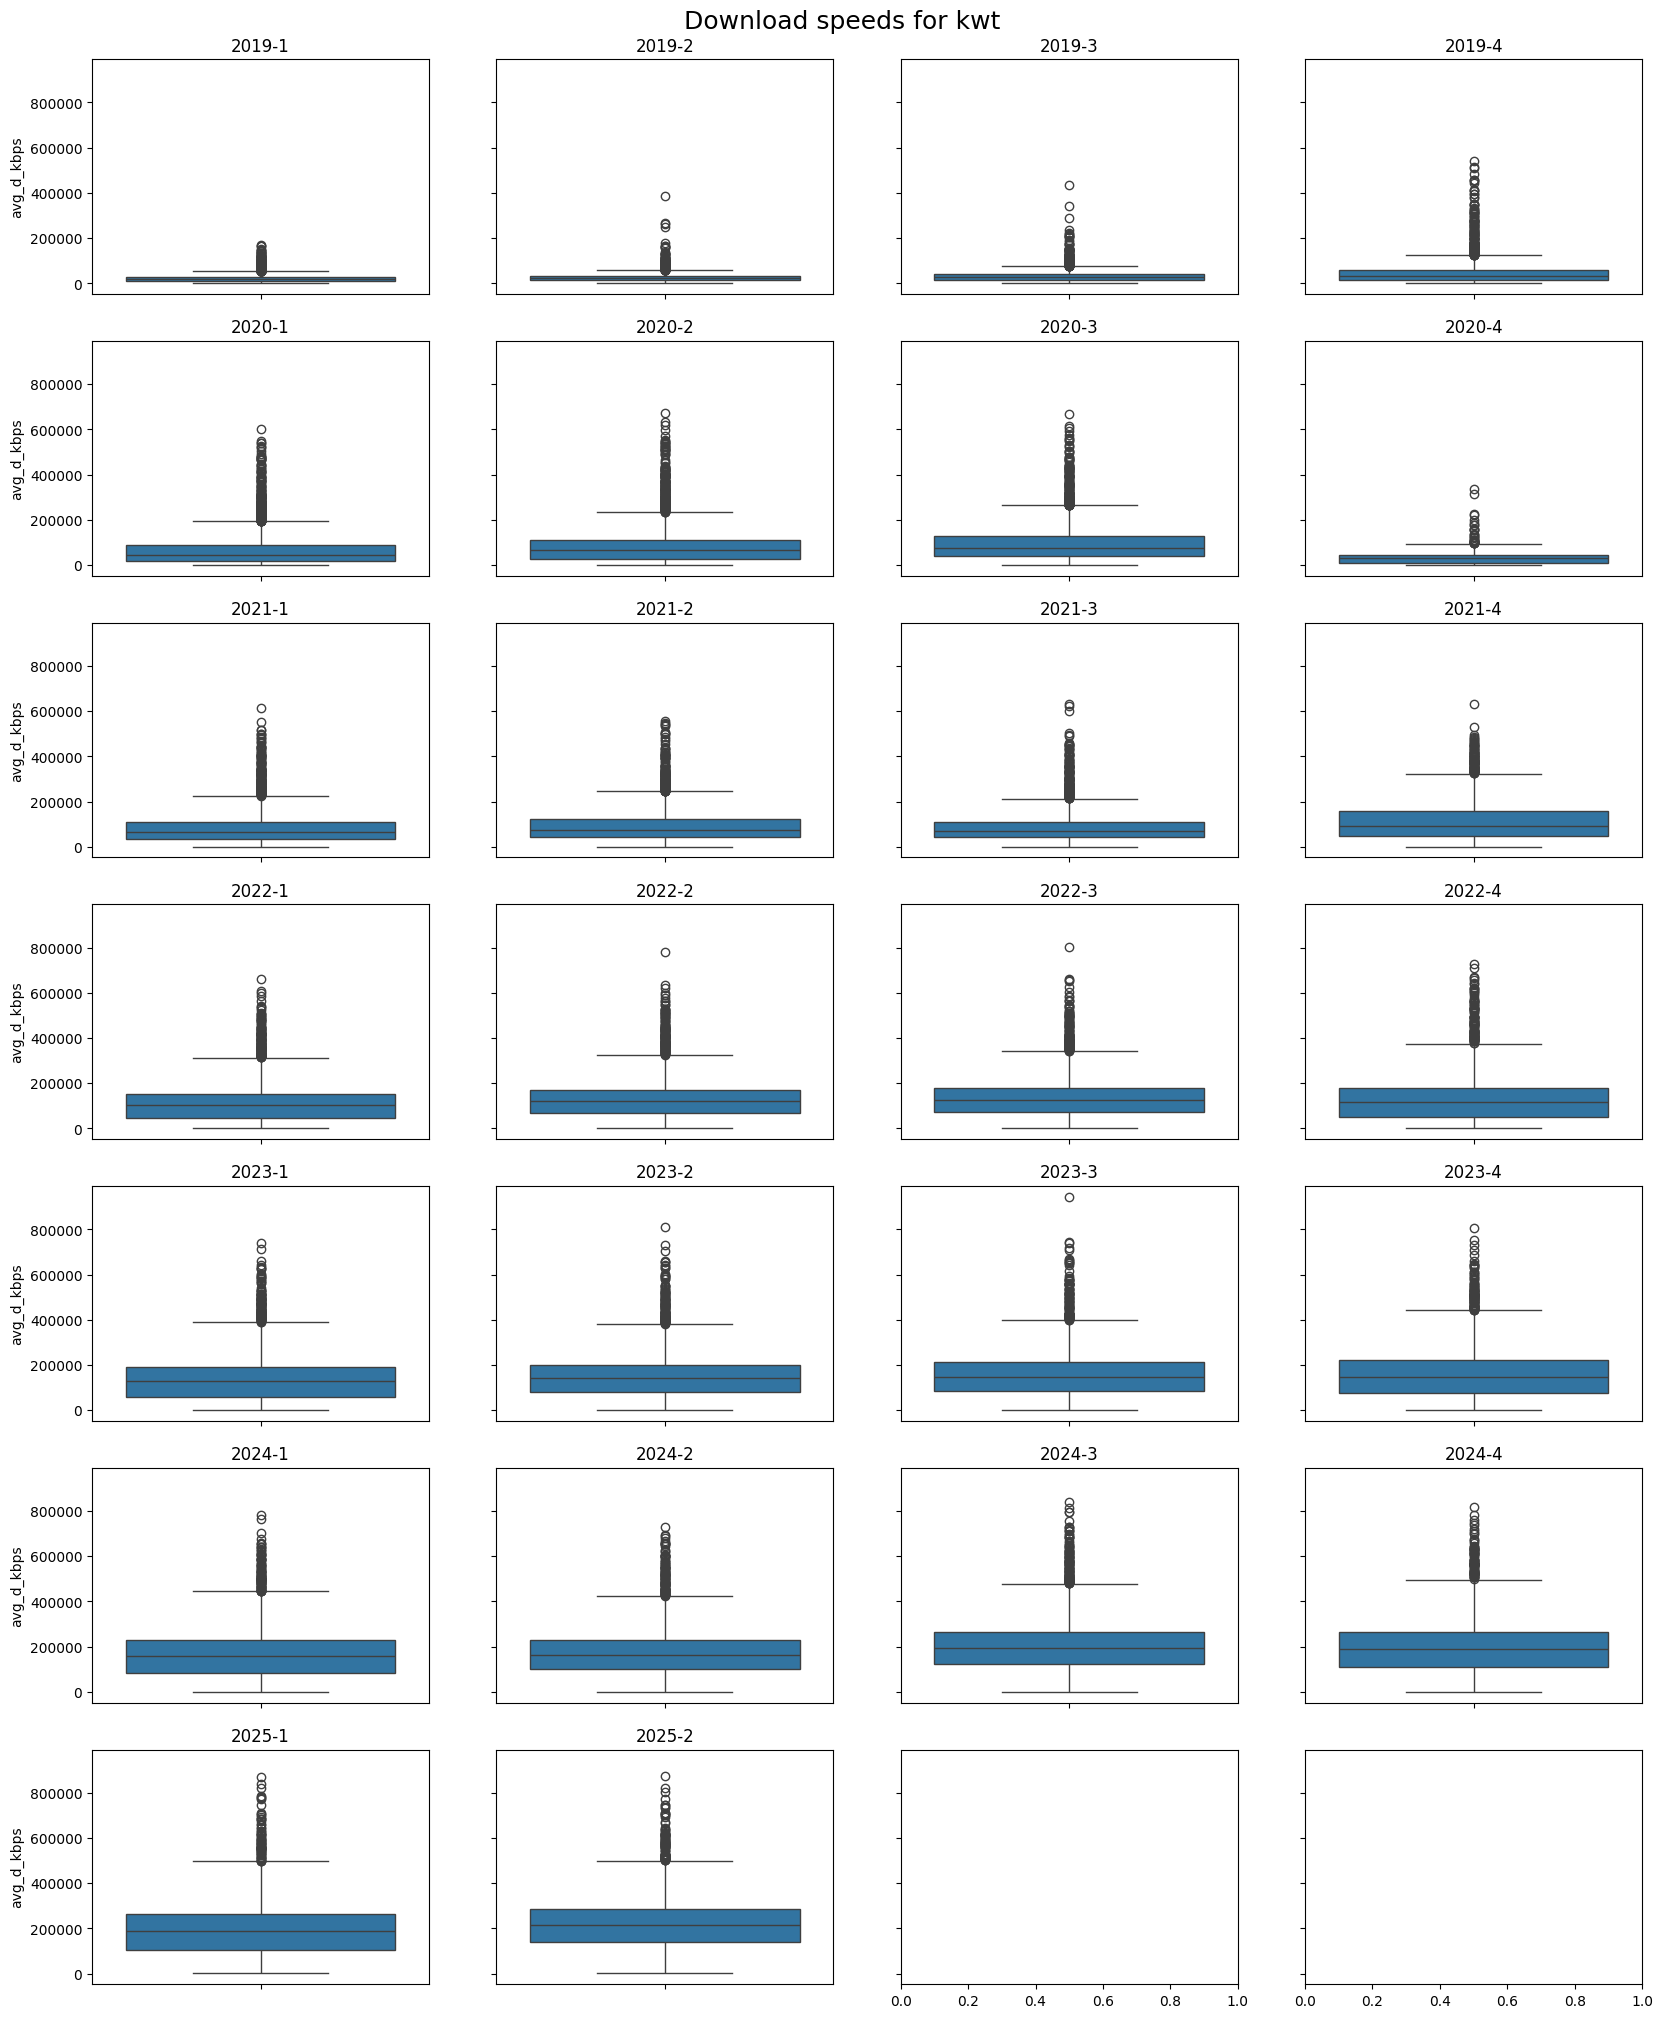

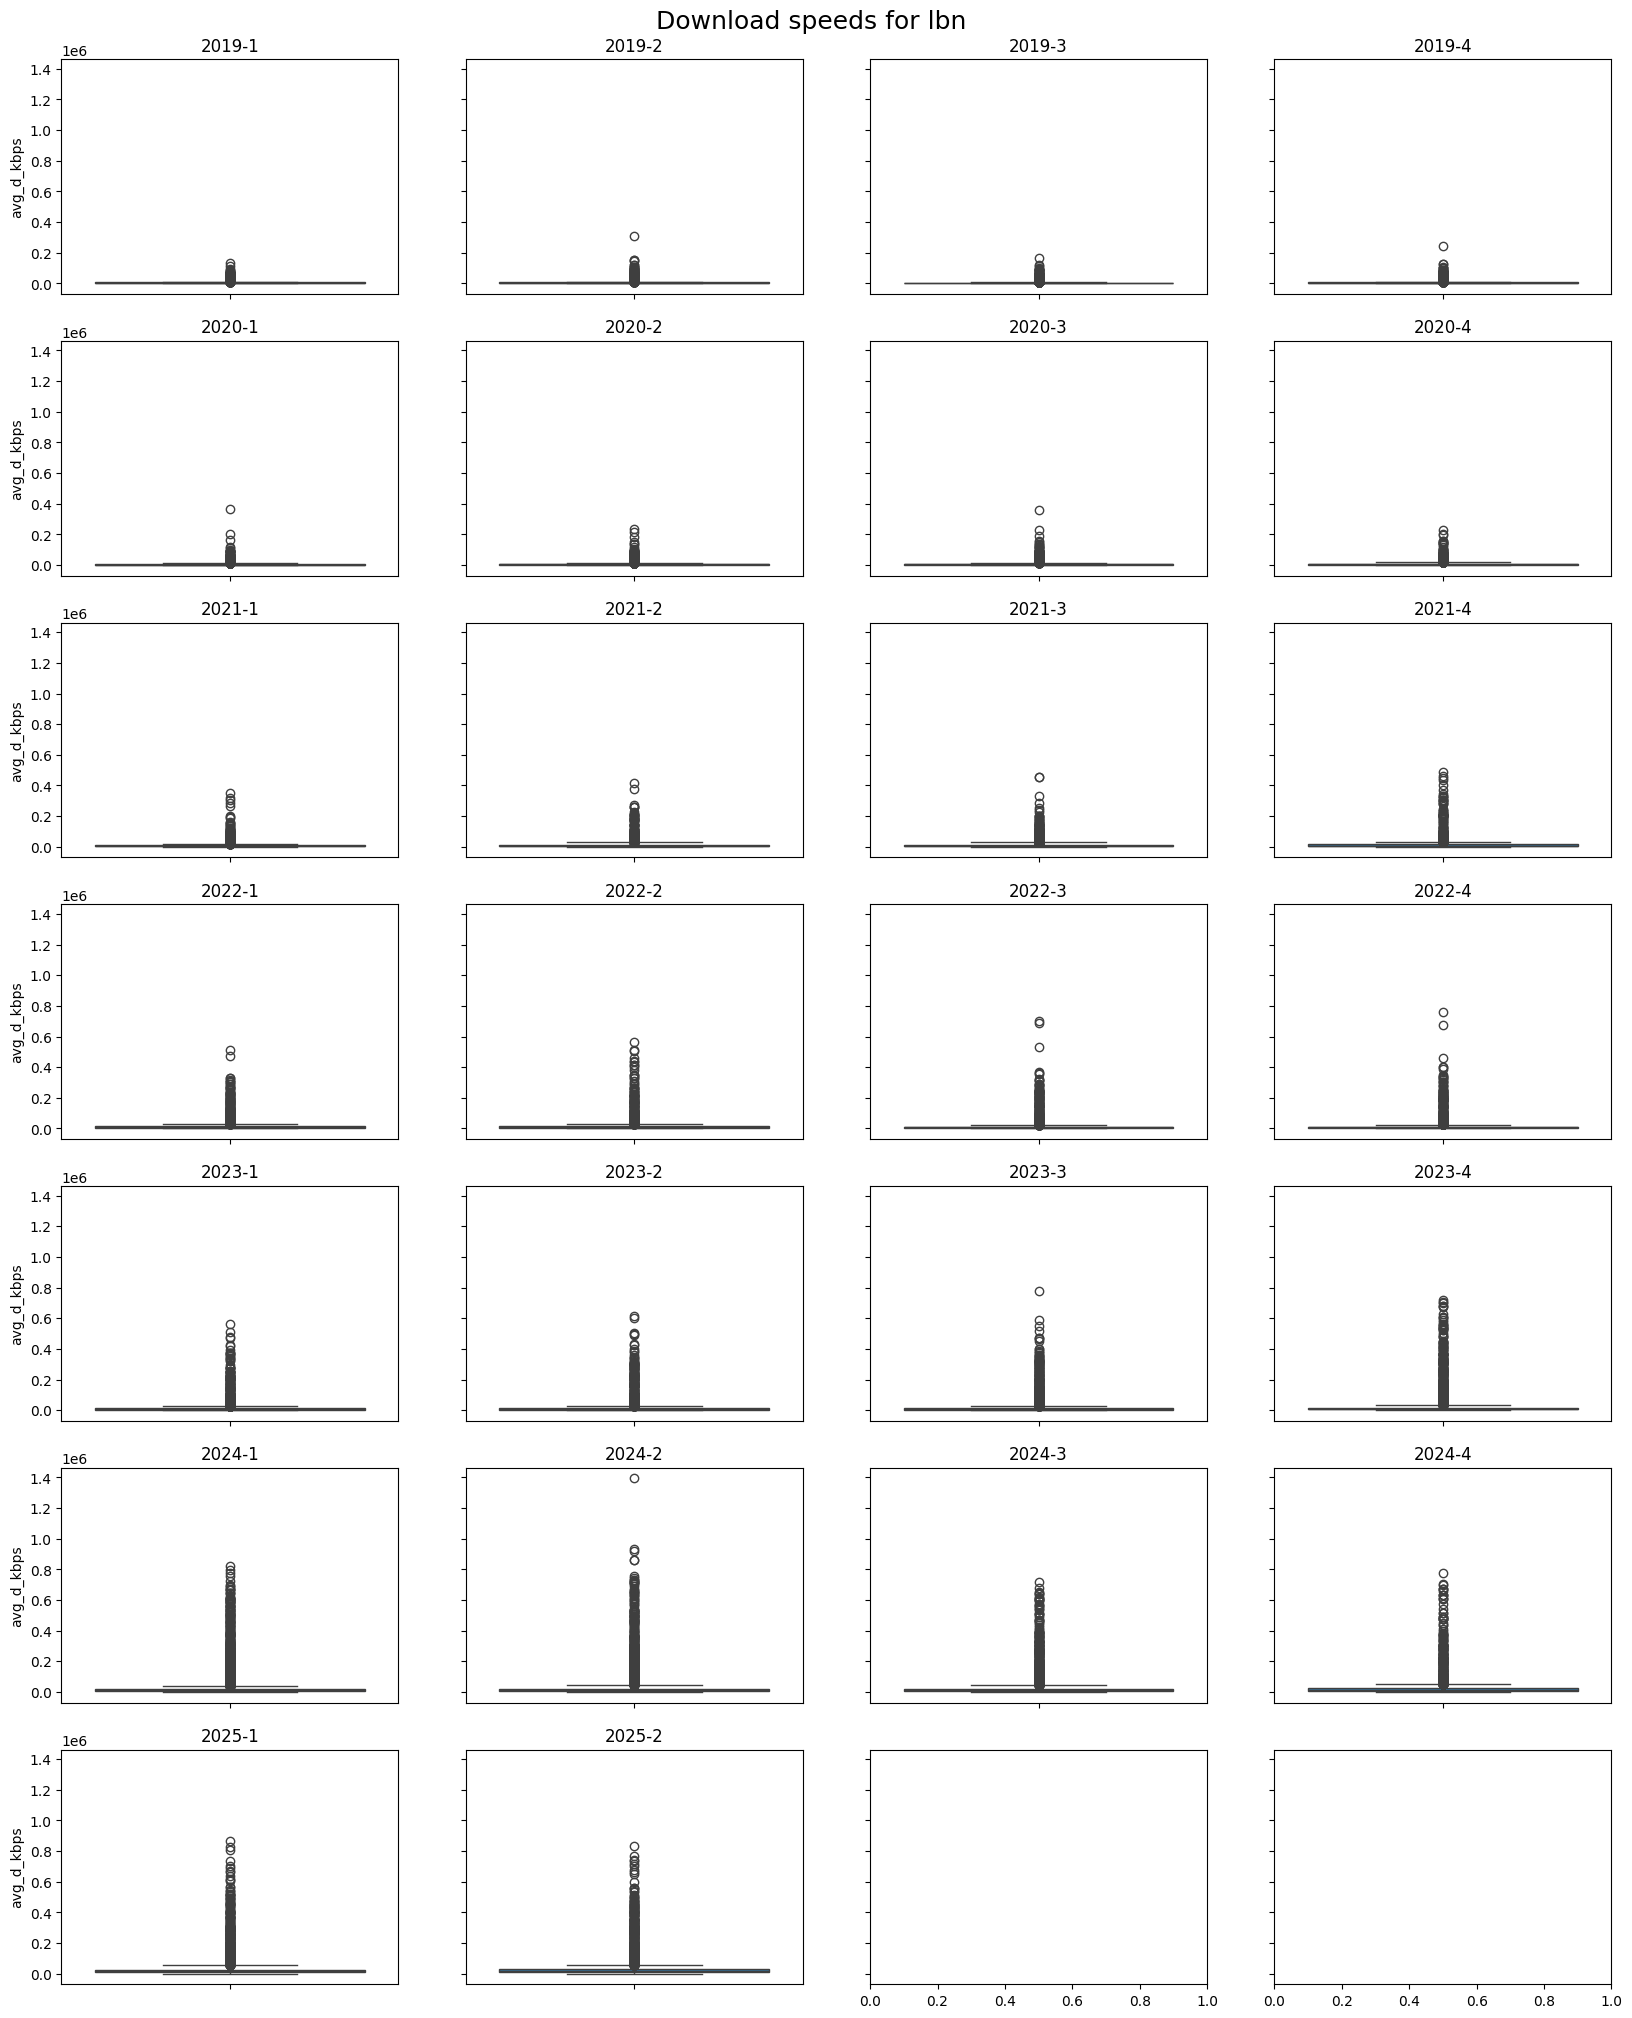

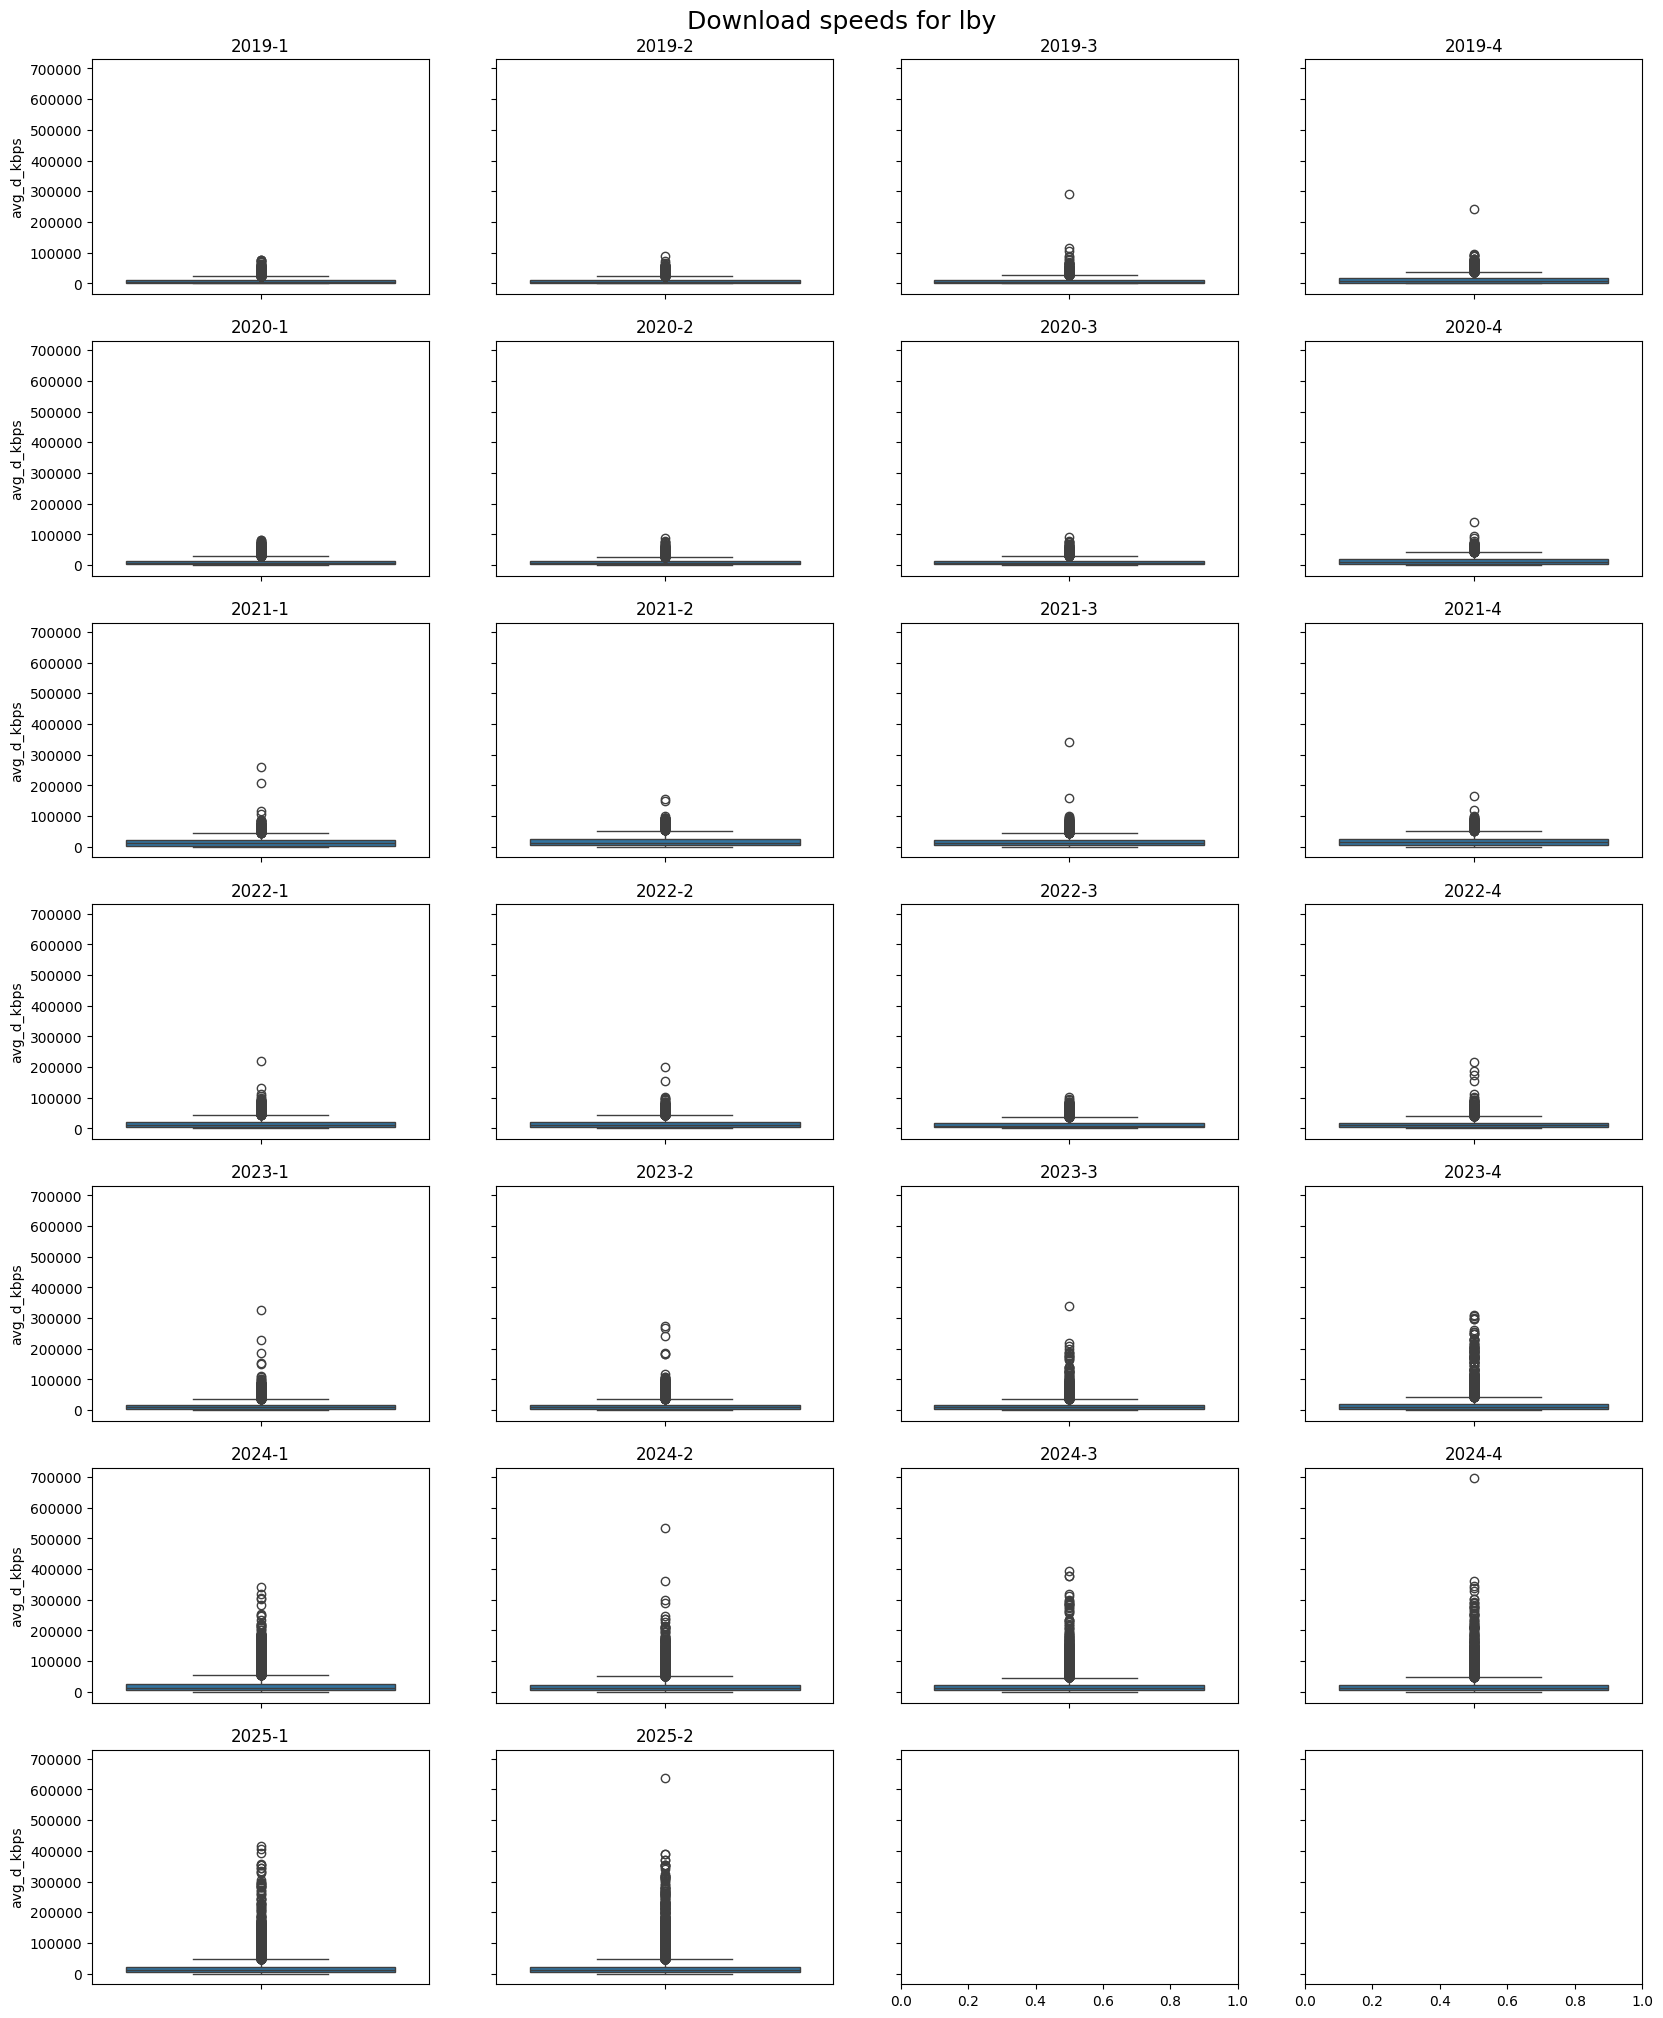

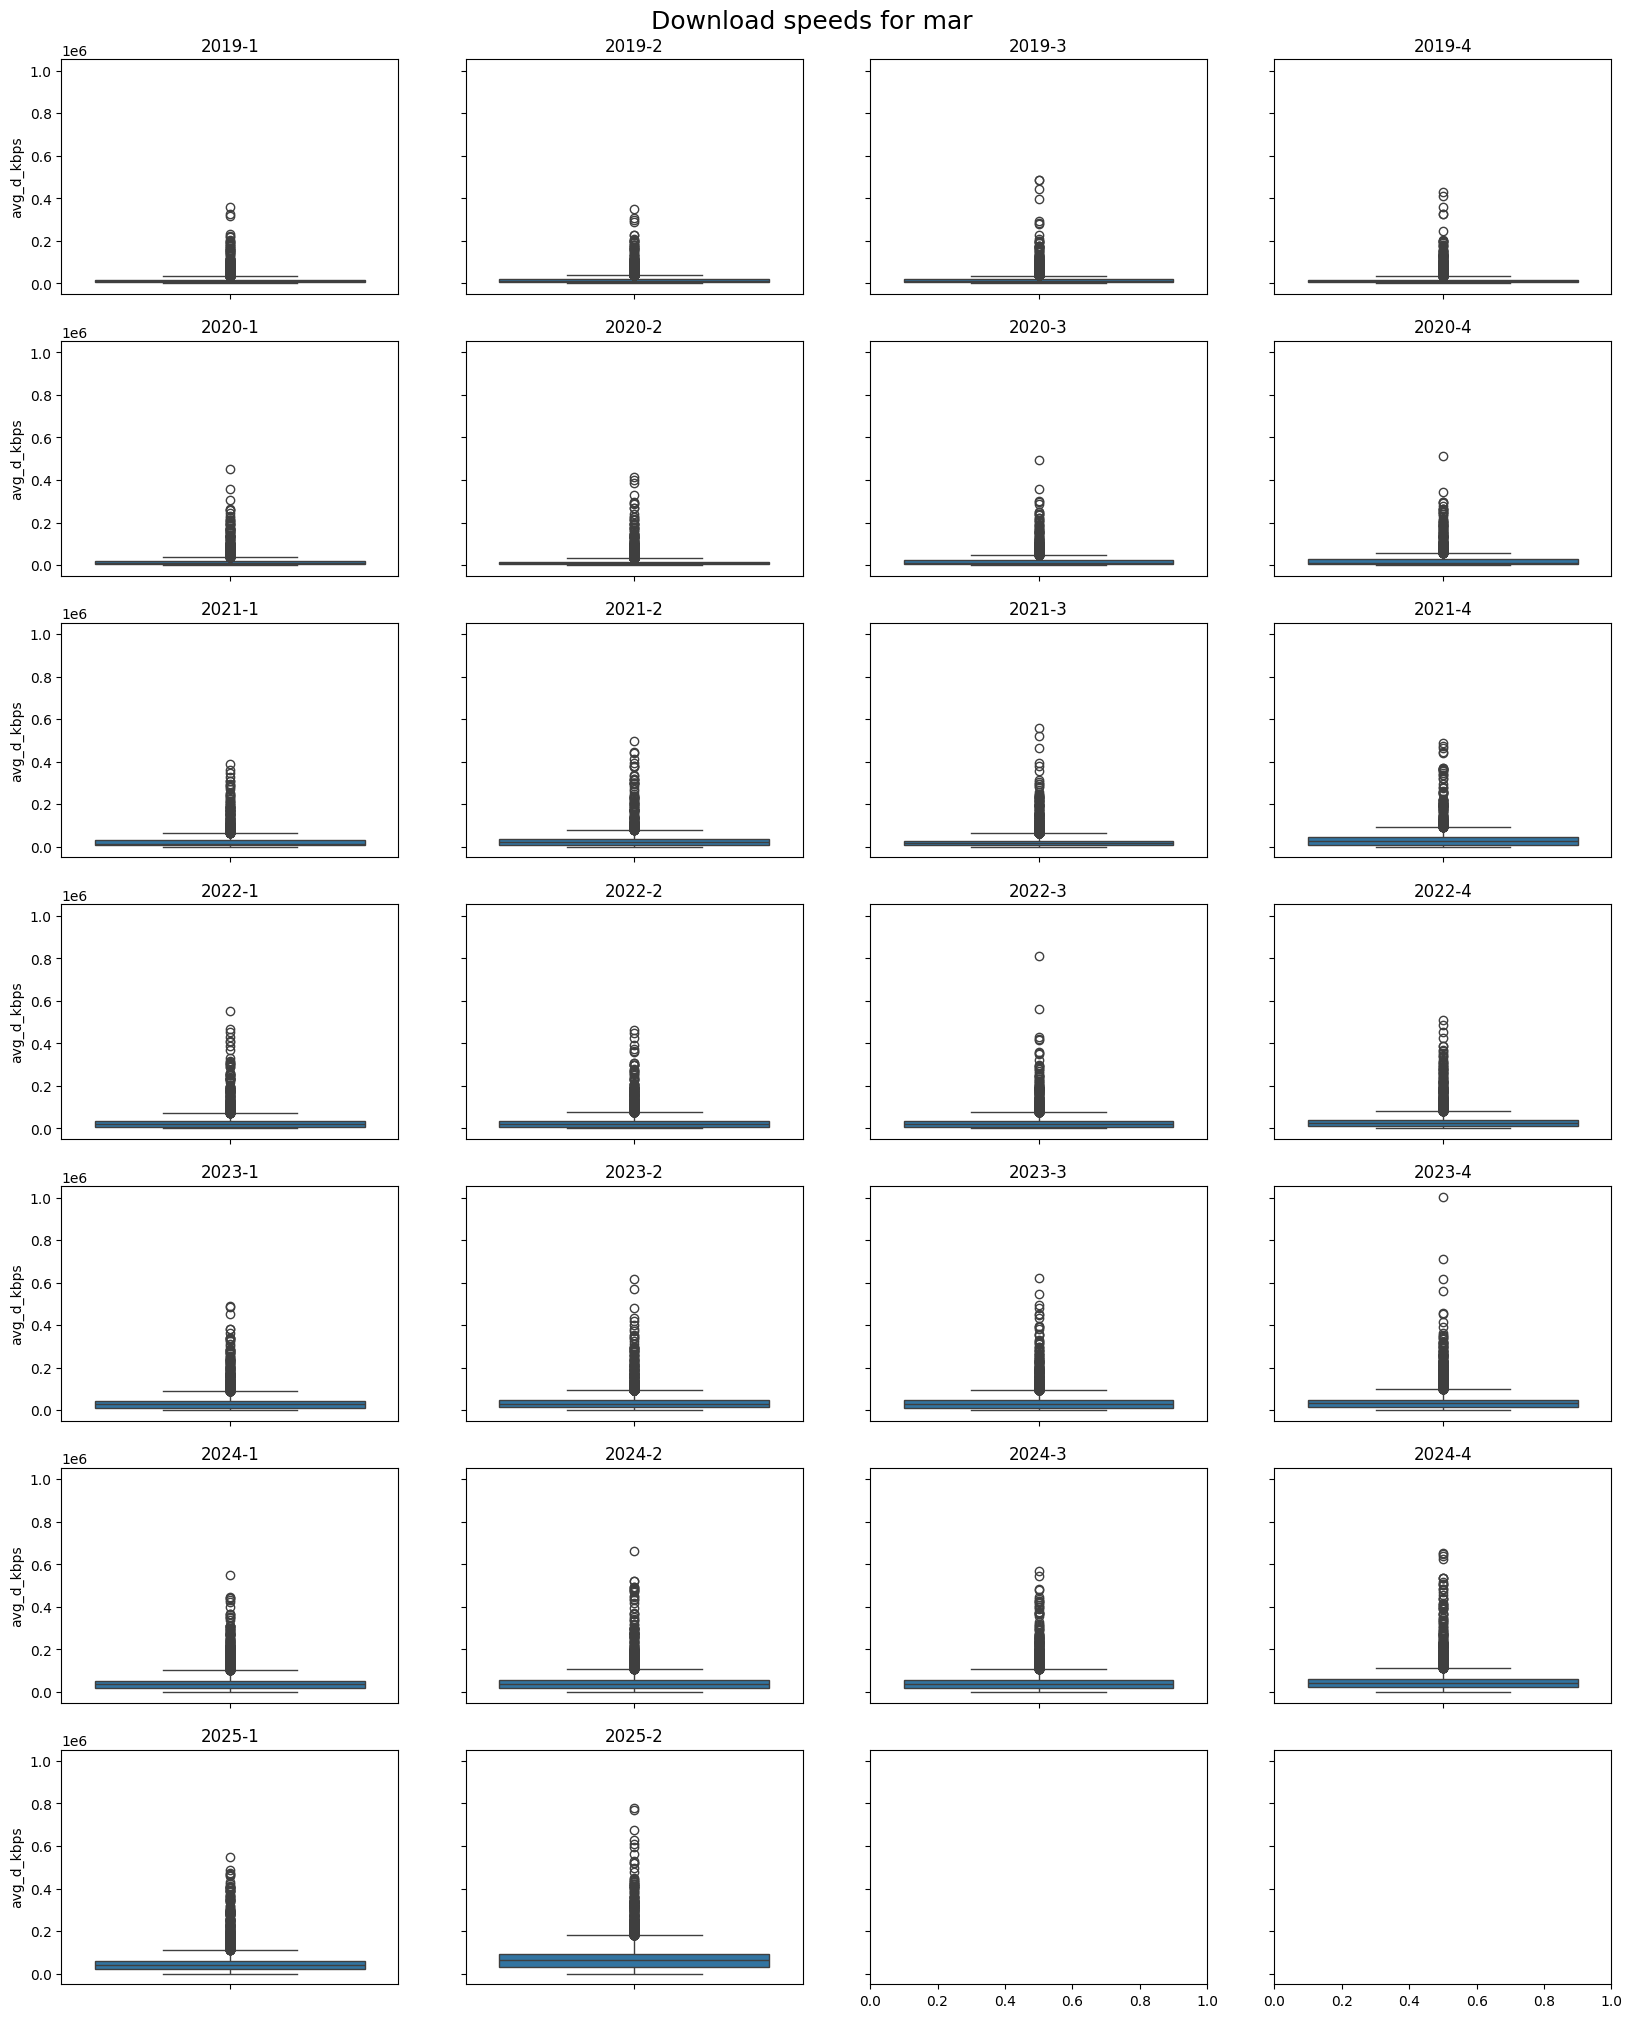

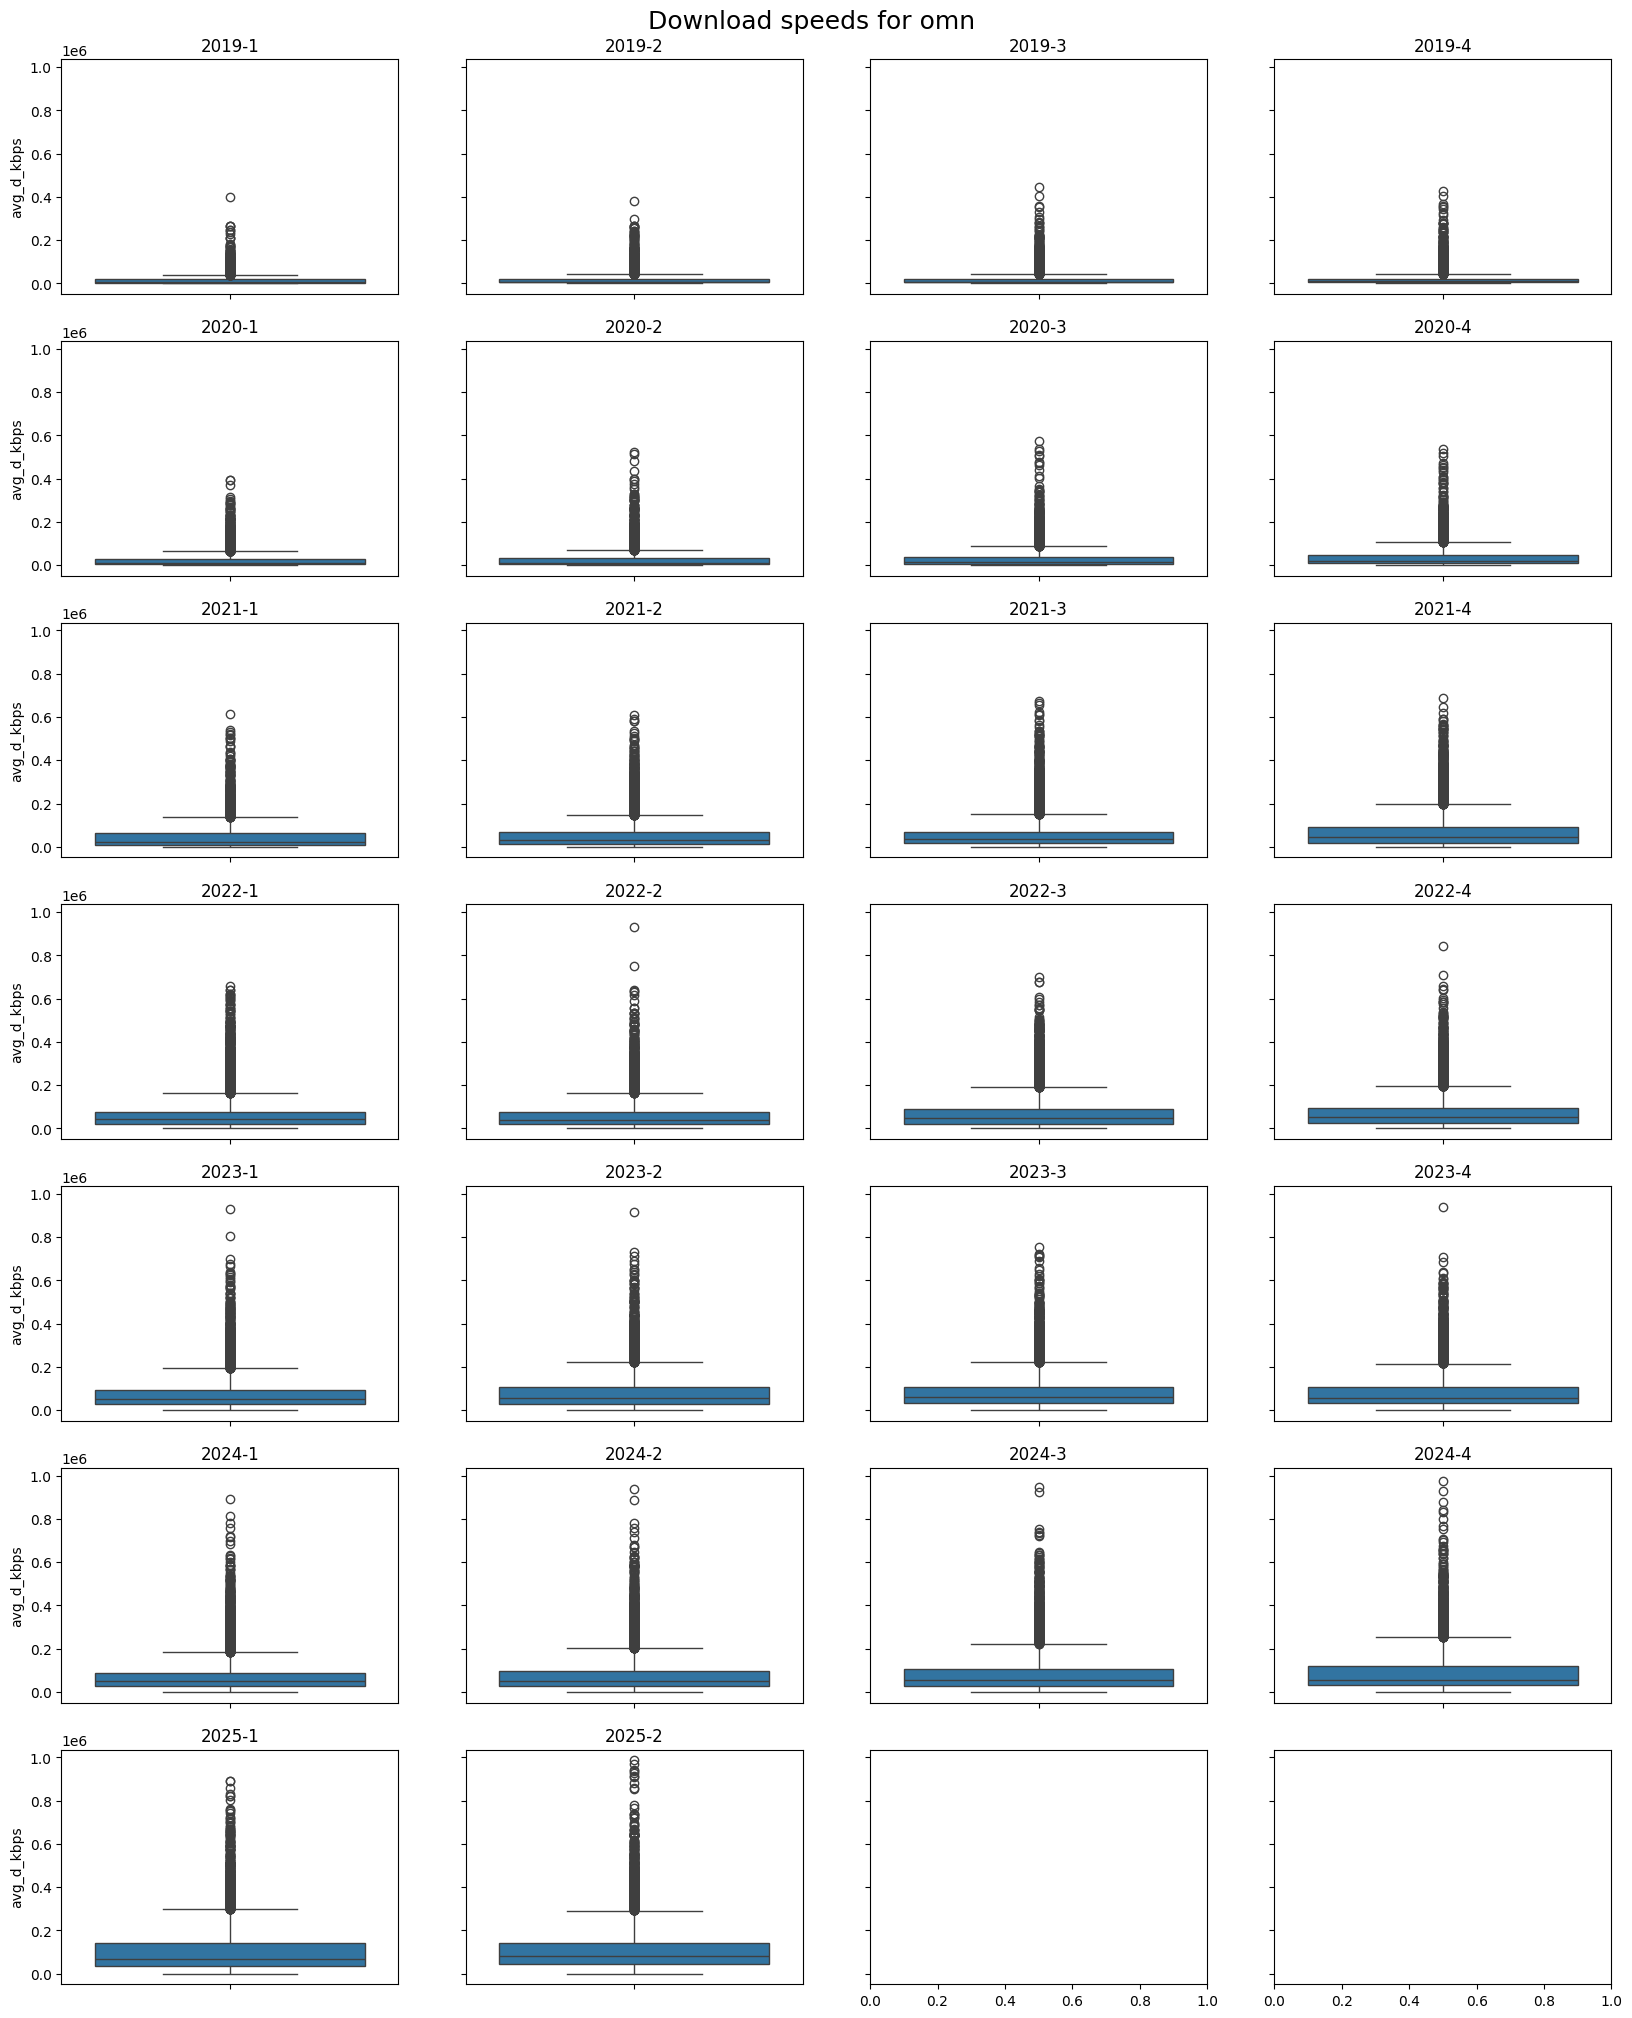

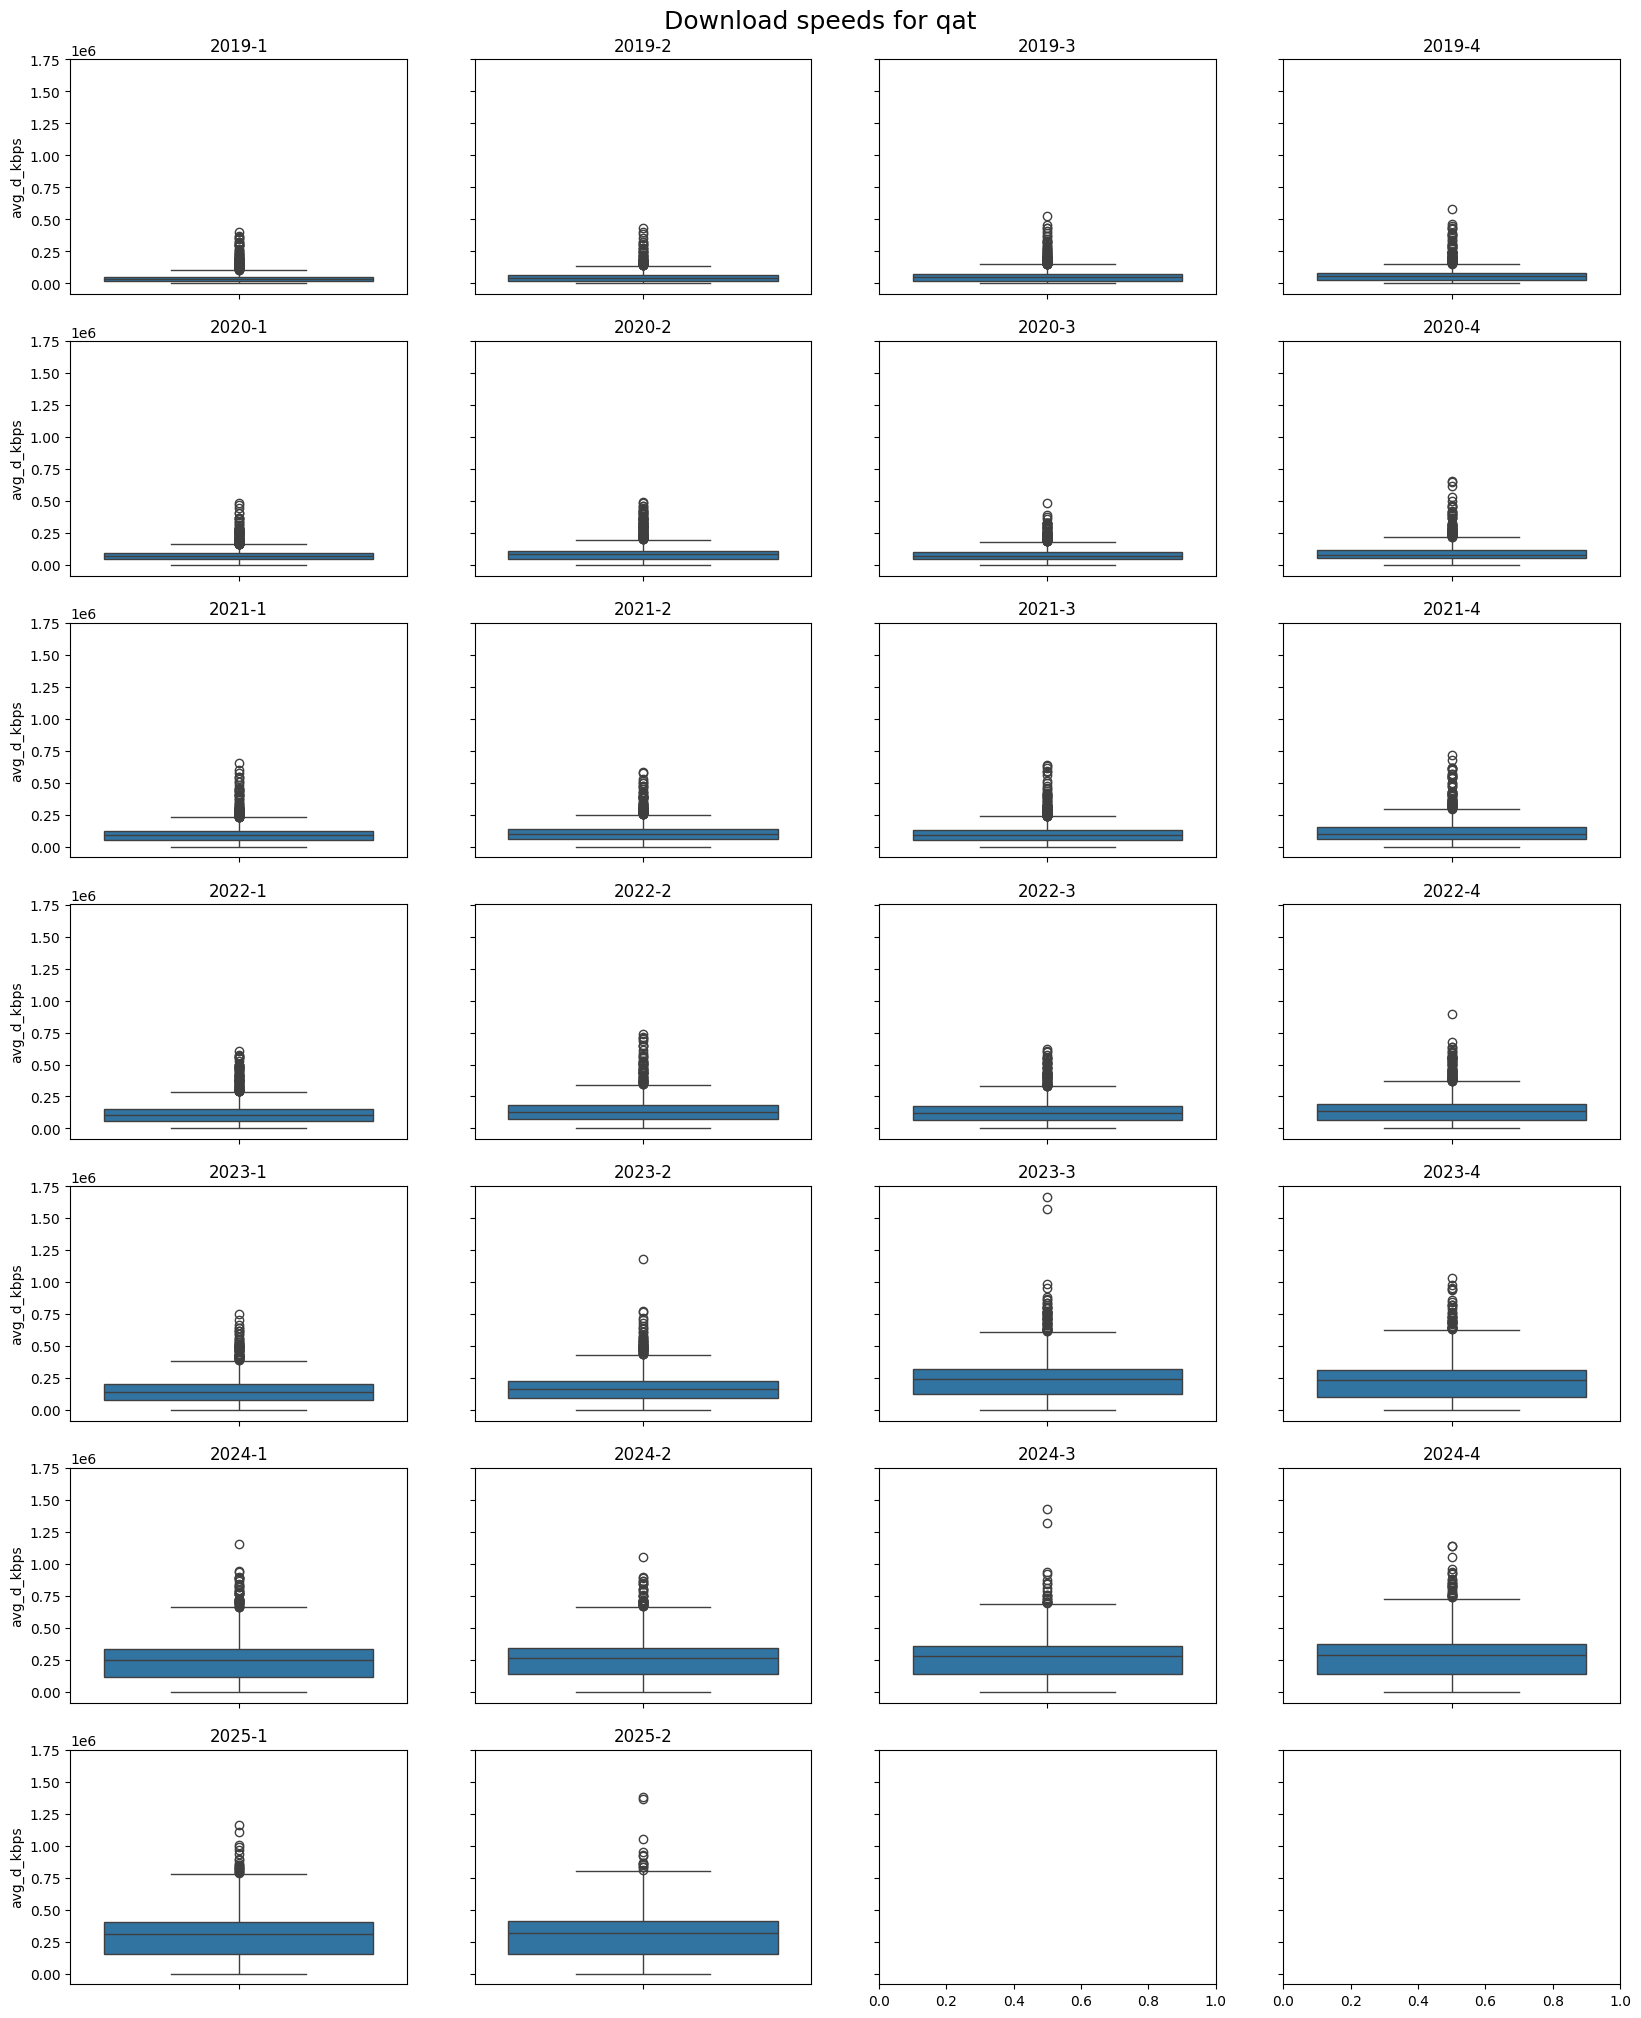

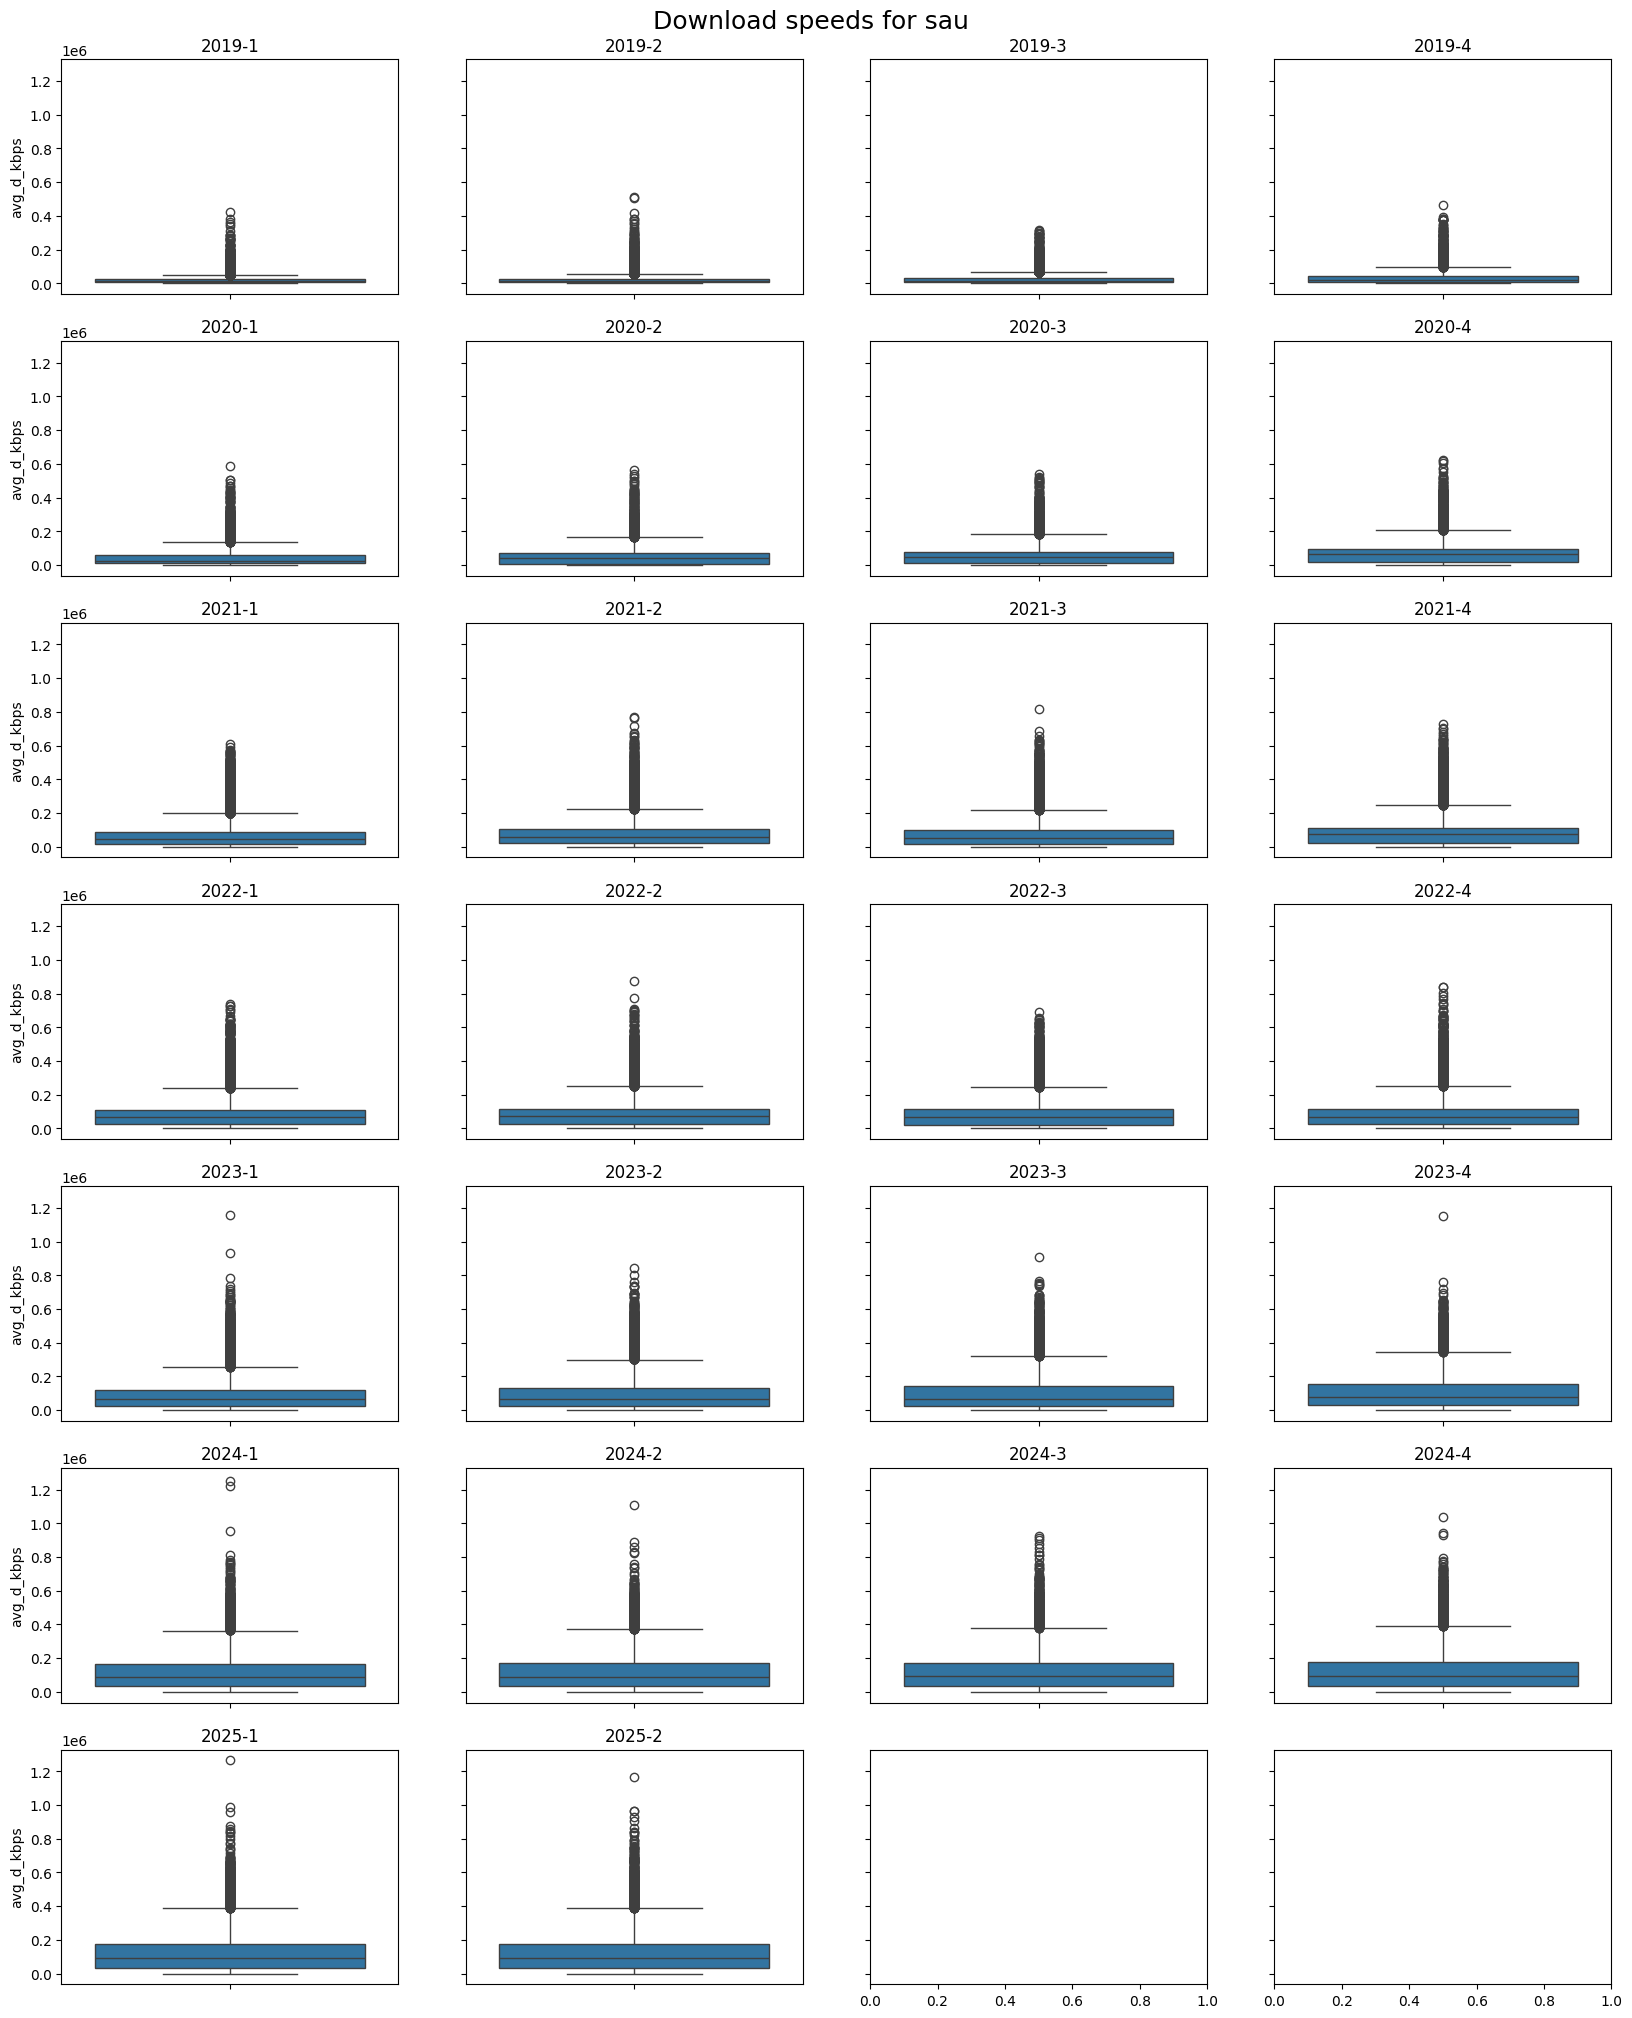

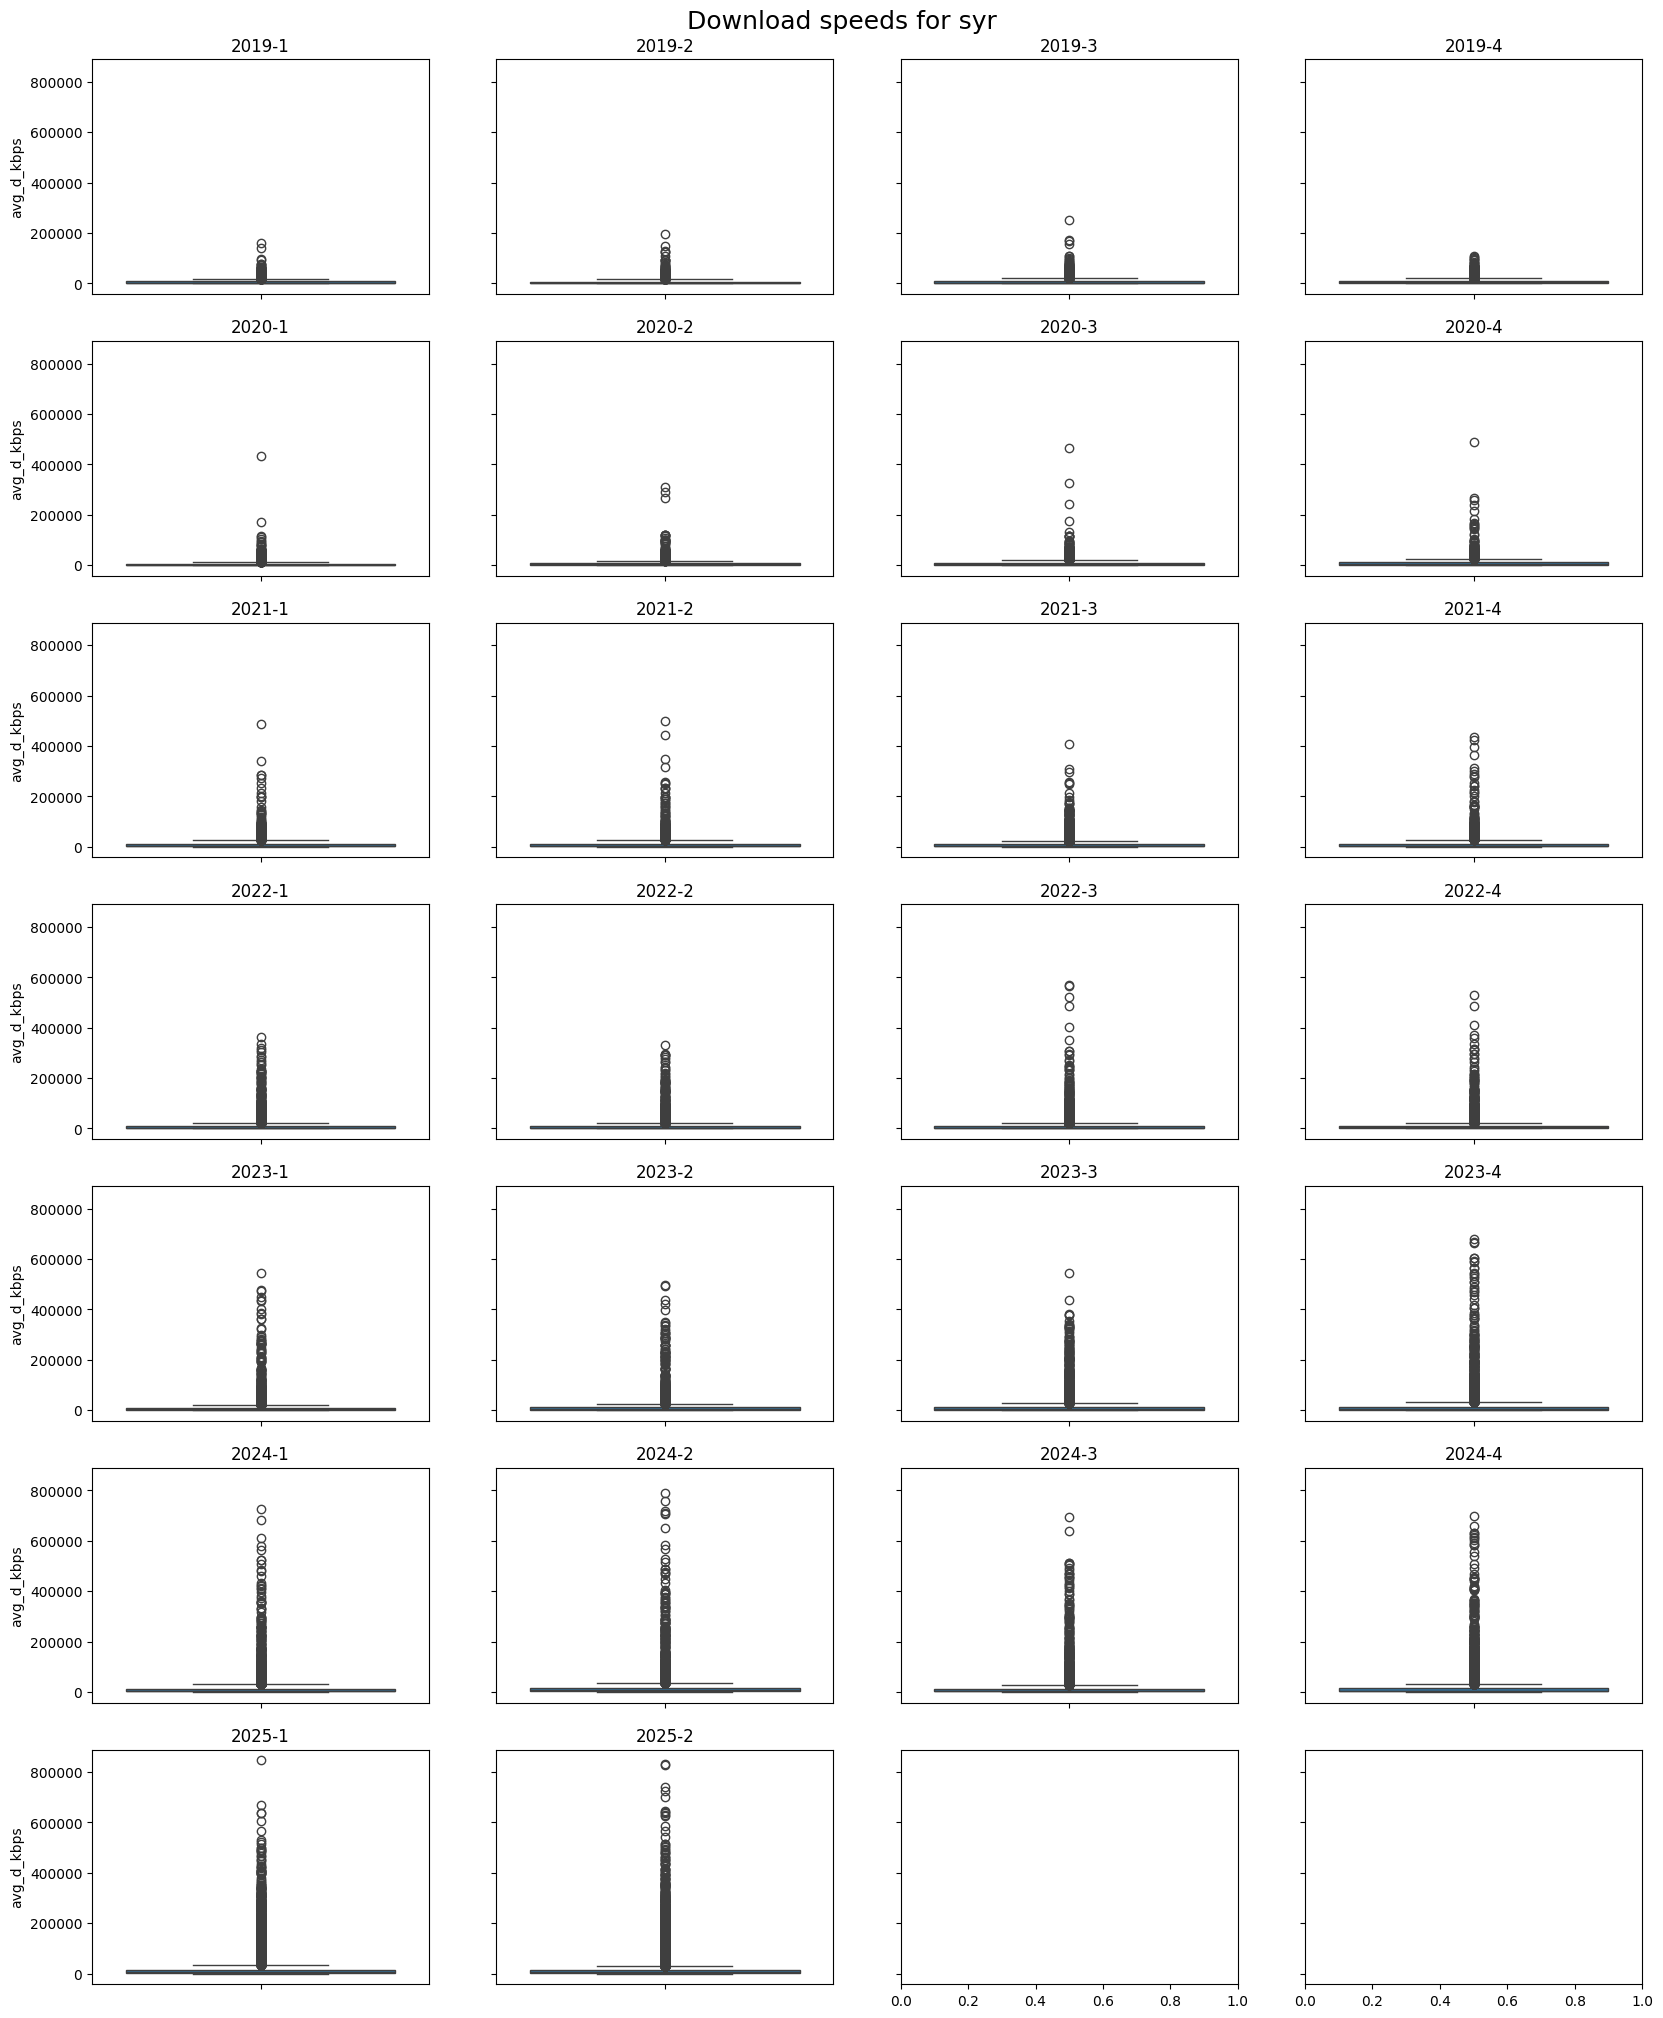

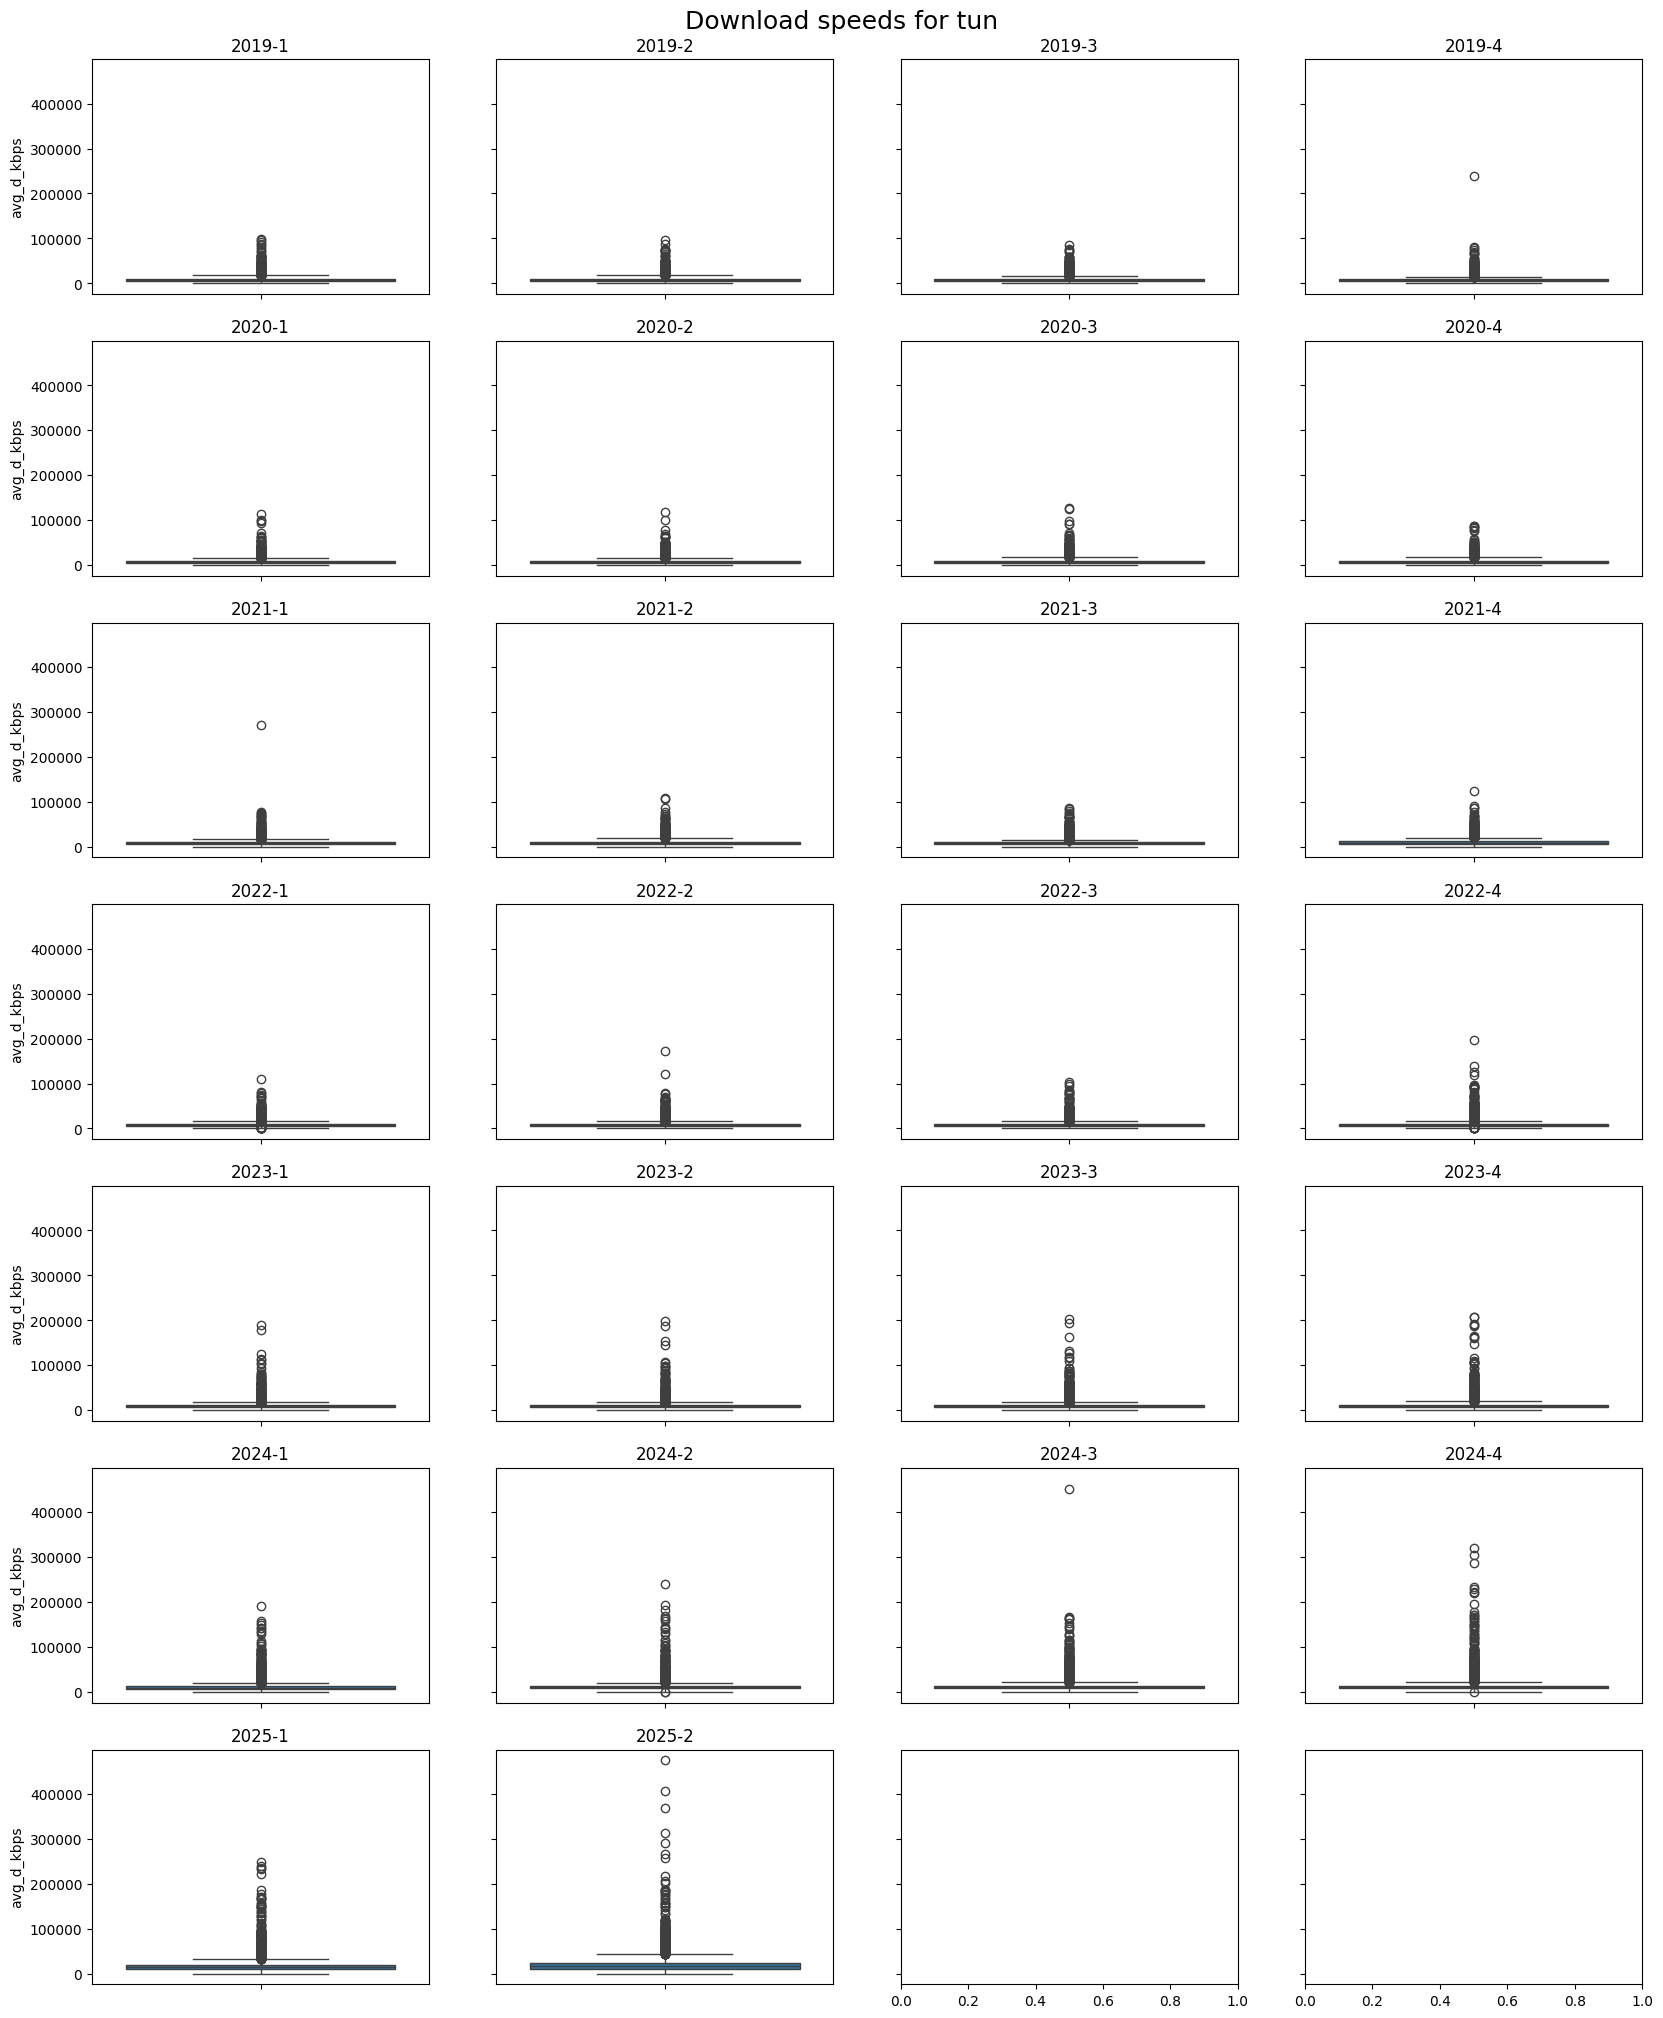

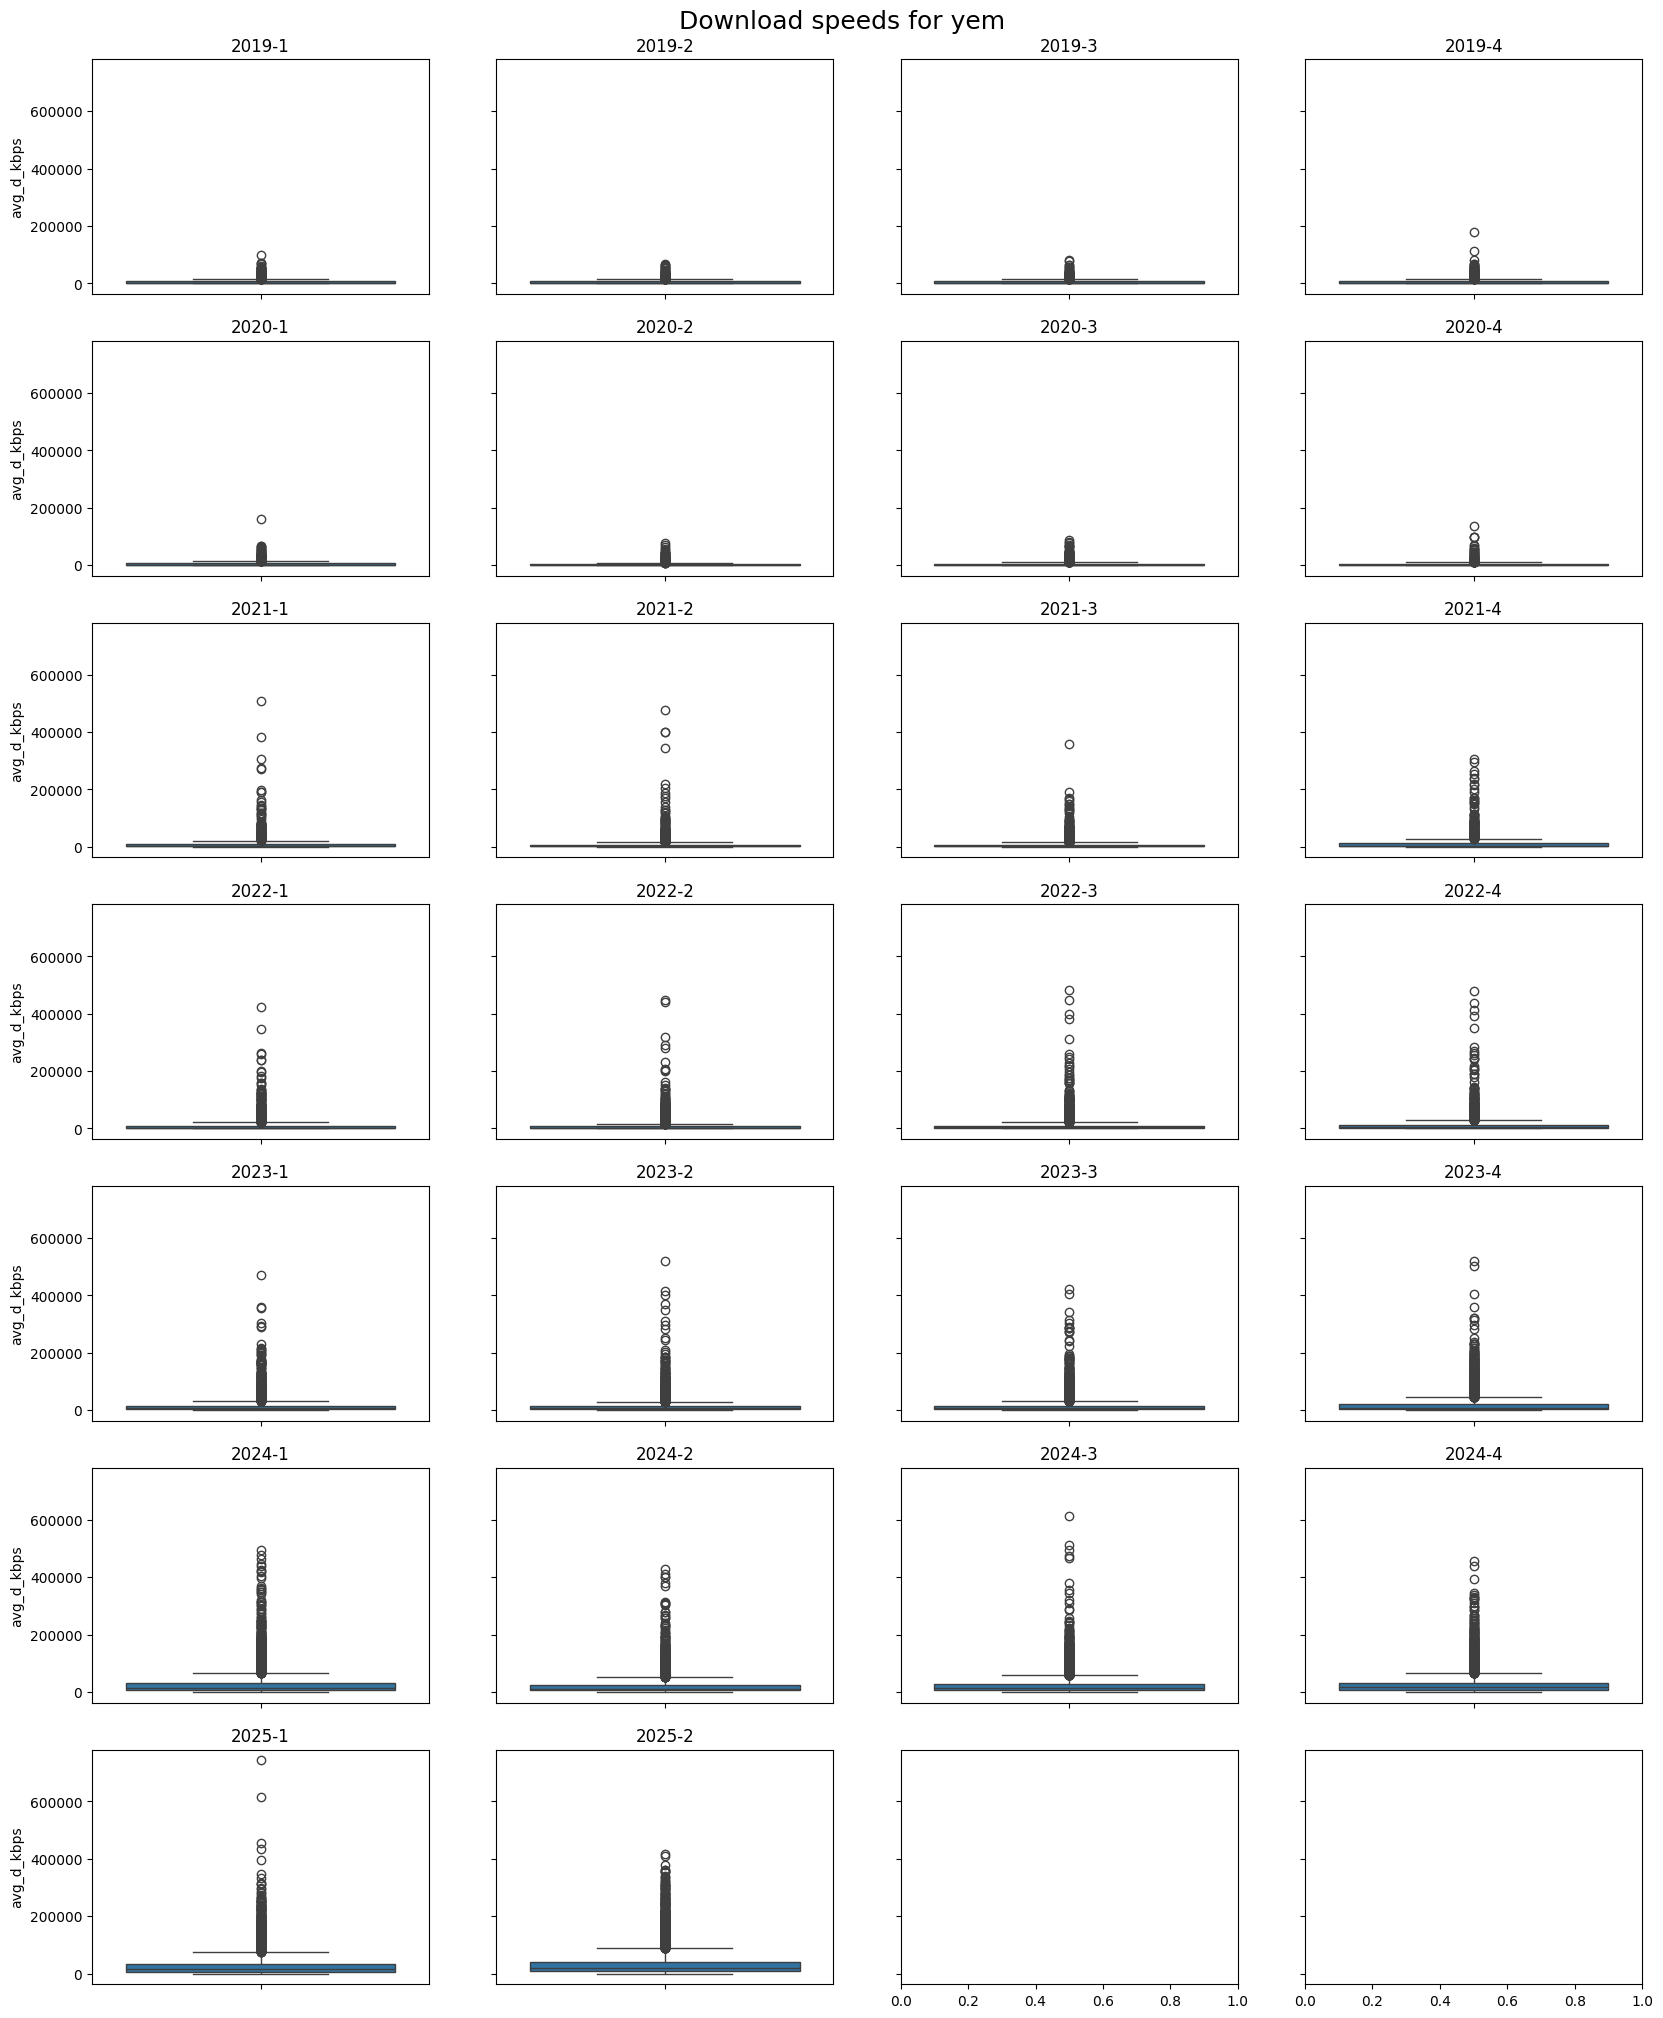

In [6]:
# how the gdf was calculated is show in the following section
countries_gdf = {}

for iso_code in iso_codes:
    gdf=gpd.read_file(f'../results/gdf_{iso_code}.gpkg')
    gdf.set_index('index', inplace = True)
    fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 25), sharey=True)
    fig.suptitle(f"Download speeds for {iso_code}", fontsize=18, y=.9) 
    
    for year in range(2019, 2026):
        for quarter in range(1, 5):
            if (quarter > 2) & (year == 2025):
                continue
            path = path_data + f'type={net_type}/year={year}/quarter={quarter}/'
            df = pd.read_parquet(path, engine="pyarrow")
            df[f'quadkey_z{zoom}'] = df['quadkey'].apply(lambda x: x[:zoom])
            data_country = df[df['quadkey_z12'].isin(gdf.index)]
            sns.boxplot(data=data_country, y='avg_d_kbps', ax=axes[year - 2019][quarter-1])
            axes[year - 2019][quarter-1].set_title(f'{year}-{quarter}', fontsize=12)
    
    plt.show()

### Coverage by country for Q2 - 2025

In [24]:
def plot_speed_test_availability(iso_code, gdf, boundary, ax):
    # fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    boundary.boundary.plot(ax=ax, edgecolor="#D3D3D3", linewidth=0.5)
    im = gdf.plot(
            column="avg_download_2025_1",
            ax=ax,
            legend=True,
            cmap="Spectral",
        )
    ax.set_title(f"Speedtest - {iso_code}")

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    leg = ax.get_legend()
    if leg is not None:
        leg.set_title("Mbps")
        
    # plt.show()

In [13]:
countries_gdf = {}
for iso_code in iso_codes:
    gdf=gpd.read_file(f'../results/gdf_{iso_code}_with_variables.gpkg')
    gdf.set_index('index', inplace = True)
    countries_gdf[iso_code] = gdf

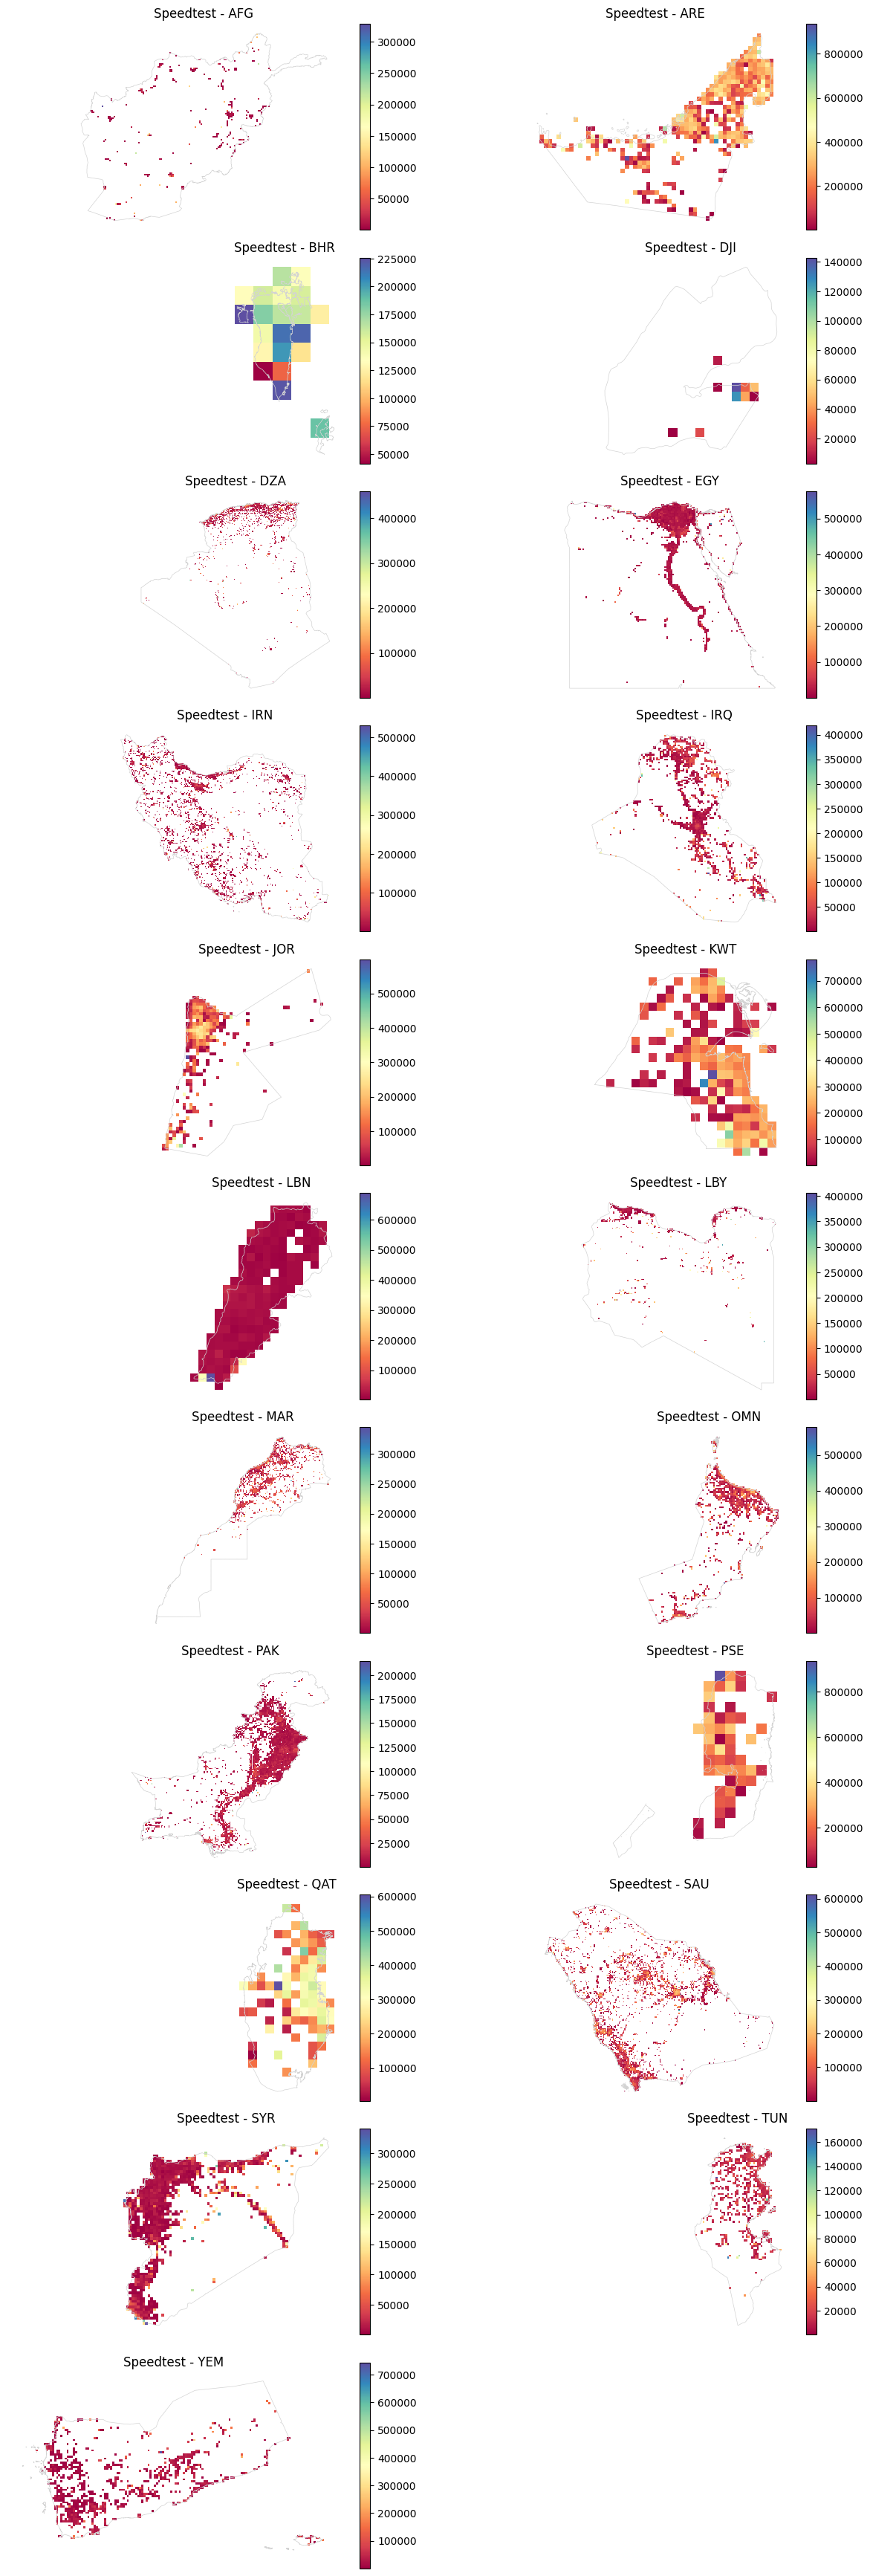

In [27]:
fig, ax = plt.subplots(11, 2, figsize=(12, 35))
ax = ax.flatten()
i = 0
for iso_code, gdf in countries_gdf.items():
    boundary = gpd.read_file(path_data + f'admin_boundaries/{iso_code}_ADM0_gbOpen.geojson')
    plot_speed_test_availability(iso_code, gdf, boundary, ax[i])
    plt.tight_layout()
    i +=1
ax[21].set_visible(False)